In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler

import sys
import gc
sys.path.append("../src")
import FE

In [2]:
kaggle_data_folder = "/home/vincent/Kaggle/data/ventilator-pressure-prediction"
output_folder = "../output/"

In [3]:
train = pd.read_csv(kaggle_data_folder + "/train.csv")
test = pd.read_csv(kaggle_data_folder + "/test.csv")

In [4]:
public_best_score = pd.read_csv("../input/public_best_148.csv")
public_best_score.head()

id  pressure
0   1  6.259305
1   2  5.978096
2   3  7.102930
3   4  7.595045
4   5  9.141693

In [5]:
test["pressure"] = public_best_score["pressure"]

In [6]:
display(train.shape, test.shape)
display(train.head())
display(test.head())

(6036000, 8)

(4024000, 8)

id  breath_id   R   C  time_step       u_in  u_out   pressure
0   1          1  20  50   0.000000   0.083334      0   5.837492
1   2          1  20  50   0.033652  18.383041      0   5.907794
2   3          1  20  50   0.067514  22.509278      0   7.876254
3   4          1  20  50   0.101542  22.808822      0  11.742872
4   5          1  20  50   0.135756  25.355850      0  12.234987

id  breath_id  R   C  time_step       u_in  u_out  pressure
0   1          0  5  20   0.000000   0.000000      0  6.259305
1   2          0  5  20   0.031904   7.515046      0  5.978096
2   3          0  5  20   0.063827  14.651675      0  7.102930
3   4          0  5  20   0.095751  21.230610      0  7.595045
4   5          0  5  20   0.127644  26.320956      0  9.141693

# EDA

## General Information

In [7]:
train.groupby("breath_id").size().unique(), test.groupby("breath_id").size().unique(), len(train.id.unique())

(array([80]), array([80]), 6036000)

In [8]:
# only one place to for u_out from 0 to 1
np.all(train.groupby("breath_id")["u_out"].apply(lambda s: s.diff().sum()) == 1)

True

In [9]:
num_train_breath_id = train.shape[0] // 80
num_test_breath_id = test.shape[0] // 80
print(num_train_breath_id, num_test_breath_id)

75450 50300


In [10]:
group_u_out_stats = train.groupby("breath_id")['u_out'].mean()
group_u_out_stats.describe()

count    75450.000000
mean         0.620449
std          0.014161
min          0.600000
25%          0.612500
50%          0.625000
75%          0.637500
max          0.687500
Name: u_out, dtype: float64

<AxesSubplot:>

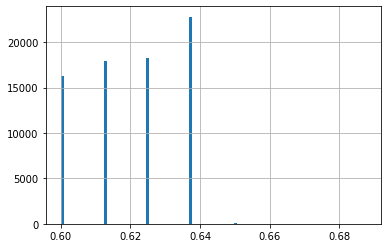

In [11]:
# u_out == 1 ratio
breath_len = 80
group_u_out_stats.hist(bins=100)

In [12]:
train.groupby(["R","C"]).size() // 80

R   C 
5   10     8312
    20     8277
    50     8271
20  10     6070
    20     6208
    50     8186
50  10    13677
    20     8260
    50     8189
dtype: int64

In [13]:
test.groupby(["R","C"]).size() // 80

R   C 
5   10    5437
    20    5451
    50    5447
20  10    4292
    20    4088
    50    5500
50  10    9081
    20    5503
    50    5501
dtype: int64

## Time Step Plot

In [14]:
def plot_breath(idx, train, ax):
    breath_seq = train.query(f"breath_id == {idx}").reset_index(drop=True)
    R, C = breath_seq.loc[0, ['R','C']]
    breath_seq.set_index('time_step',inplace=True,drop=True)
    u_in = breath_seq['u_in']
    change_place = breath_seq['u_out'].diff().idxmax()
    pressure = breath_seq["pressure"]
    
    ax.set_title(f"id {idx}: R {int(R)}, C {int(C)}")
    ax.plot(u_in, label="u_in", color="b")
    ax.axvline(x=change_place, linestyle="--", alpha=1, label="0->1", color="black")
    ax2 = ax.twinx()
    ax2.plot(pressure, label="pressure", color="r")
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")
    return 

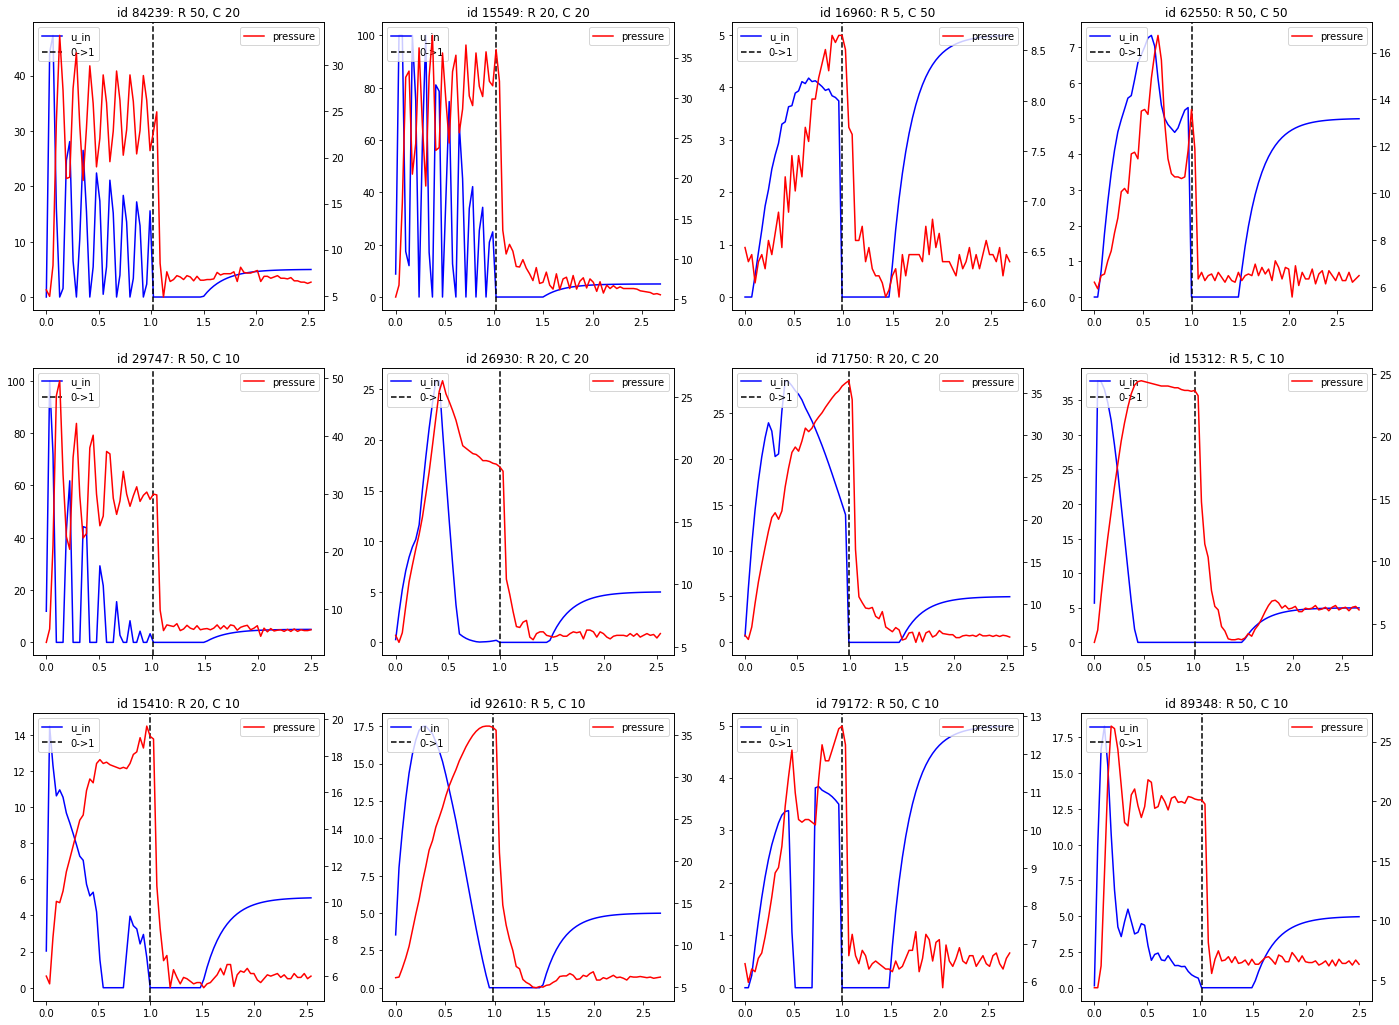

In [15]:
ids = train.breath_id.unique()
np.random.seed(10)
ids_sub = np.random.choice(ids, 12)
fig, axes = plt.subplots(3,4, figsize=(24,18))
for i, ax in enumerate(axes.flat):
    plot_breath(ids_sub[i], train, ax)

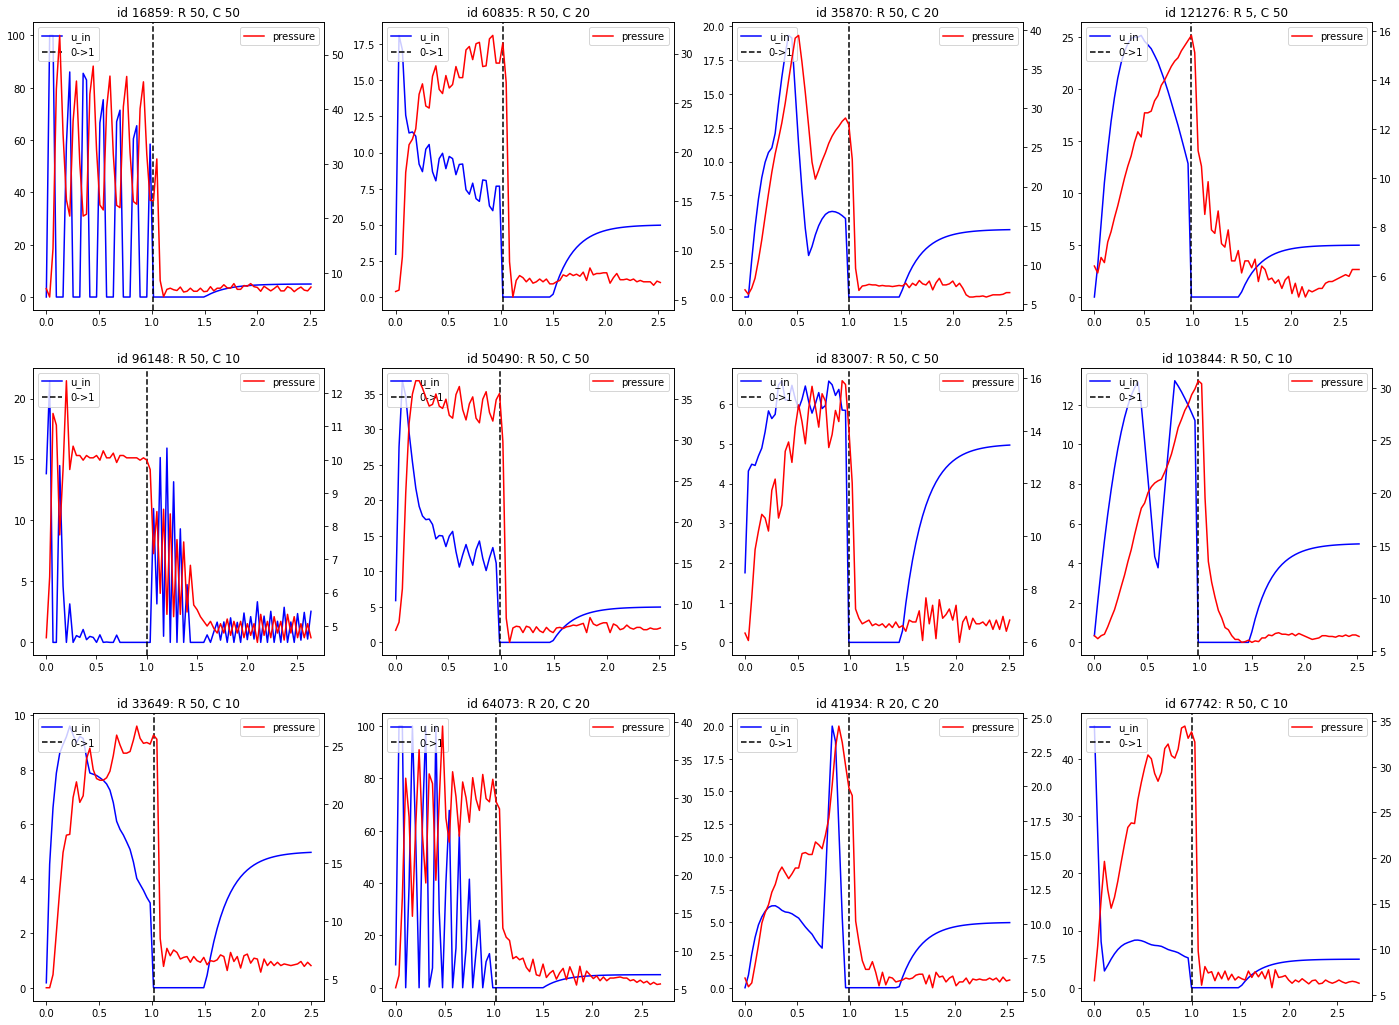

In [16]:
ids = train.breath_id.unique()
np.random.seed(11)
ids_sub = np.random.choice(ids, 12)
fig, axes = plt.subplots(3,4, figsize=(24,18))
for i, ax in enumerate(axes.flat):
    plot_breath(ids_sub[i], train, ax)

## R & C Effect

In [17]:
change_place = train.groupby(["R","C","breath_id"])["u_out"].apply(lambda s: s.diff().idxmax()-1 - s.index[0])

In [18]:
change_place_test = test.groupby(["R","C","breath_id"])["u_out"].apply(lambda s: s.diff().idxmax()-1 - s.index[0])

In [19]:
display(change_place.groupby(["R","C"]).mean())
display(change_place_test.groupby(["R","C"]).mean())

R   C 
5   10    29.003128
    20    29.877250
    50    28.706202
20  10    29.330478
    20    28.935728
    50    28.707305
50  10    29.570593
    20    29.987046
    50    29.908902
Name: u_out, dtype: float64

R   C 
5   10    29.003127
    20    29.841497
    50    28.727924
20  10    29.327819
    20    28.945205
    50    28.708727
50  10    29.595970
    20    30.008359
    50    29.890929
Name: u_out, dtype: float64

In [20]:
display(change_place.groupby(["R","C"]).max())
display(change_place_test.groupby(["R","C"]).max())

R   C 
5   10    31
    20    31
    50    31
20  10    31
    20    31
    50    31
50  10    31
    20    31
    50    31
Name: u_out, dtype: int64

R   C 
5   10    31
    20    31
    50    31
20  10    31
    20    31
    50    31
50  10    31
    20    31
    50    31
Name: u_out, dtype: int64

In [21]:
display(change_place.groupby(["R","C"]).min())
display(change_place_test.groupby(["R","C"]).min())

R   C 
5   10    27
    20    27
    50    27
20  10    28
    20    28
    50    27
50  10    24
    20    27
    50    27
Name: u_out, dtype: int64

R   C 
5   10    27
    20    27
    50    27
20  10    28
    20    28
    50    28
50  10    24
    20    27
    50    24
Name: u_out, dtype: int64

In [22]:
train["step"] = list(range(80)) * (train.shape[0] // 80)
test["step"] = list(range(80)) * (test.shape[0] // 80)

In [23]:
def feature_plot(df, df_test, feature, use_median=True, plot_test=True):
    if isinstance(feature, str):
        feature = [feature]
    f_colors = ["blue","grey","purple"]
    f_test_colors = ["green","pink","lime"]
    df.groupby("breath_id")["u_out"].apply(lambda s: s.diff().idxmax())
    if use_median:
        f_median = df.groupby(["R","C","step"])[ feature + ["pressure"]].median().reset_index()
        f_mad = df.groupby(["R","C","step"])[ feature + ["pressure"]].mad().reset_index()
        if plot_test:
            f_median_test = df_test.groupby(["R","C","step"])[ feature + ["pressure"]].median().reset_index()
            f_mad_test = df_test.groupby(["R","C","step"])[ feature + ["pressure"]].mad().reset_index()
    else:
        f_median = df.groupby(["R","C","step"])[feature + ["pressure"]].mean().reset_index()
        f_mad = df.groupby(["R","C","step"])[feature + ["pressure"]].std().reset_index()
        if plot_test:
            f_median_test = df_test.groupby(["R","C","step"])[feature + ["pressure"]].mean().reset_index()
            f_mad_test = df_test.groupby(["R","C","step"])[feature + ["pressure"]].std().reset_index()
    
    Rs = sorted(list(map(int,df["R"].unique())))
    Cs = sorted(list(map(int,df["C"].unique())))    
    fig, axes = plt.subplots(3,3,figsize=(24,24))
    axes = axes.flat
    cnt = 0
    for R in Rs:
        for C in Cs:
            ax = axes[cnt]
            ax2 = ax.twinx()
            tmp_median = f_median.query(f"R == {R} and C == {C} ").copy().iloc[:,2:].set_index("step")
            tmp_mad = f_mad.query(f"R == {R} and C == {C} ").copy().iloc[:,2:].set_index("step")
            
            for i,f in enumerate(feature):
                ax.errorbar(tmp_median.index,tmp_median[f], tmp_mad[f], label=f, lolims=True, alpha=.6, color=f_colors[i])
            ax2.errorbar(tmp_median.index,tmp_median["pressure"], tmp_mad["pressure"], label="pressure", lolims=True, alpha=.6, color="r")
            ax.axvline(x=31, linestyle="--", alpha=1, color="black")

            if plot_test:
                tmp_median_test = f_median_test.query(f"R == {R} and C == {C} ").copy().iloc[:,2:].set_index("step")
                tmp_mad_test = f_mad_test.query(f"R == {R} and C == {C} ").copy().iloc[:,2:].set_index("step")
                for i,f in enumerate(feature):
                    ax.errorbar(tmp_median_test.index,tmp_median_test[f], tmp_mad_test[f], label=f + "_test", lolims=True, alpha=.6, color=f_test_colors[i])
                ax2.errorbar(tmp_median_test.index,tmp_median_test["pressure"], tmp_mad_test["pressure"], label="pressure_test", lolims=True, alpha=.6, color="orange")
            
            ax.set_title("R {}, C: {}".format(R, C))
            ax.legend(loc="upper left")
            ax2.legend(loc="upper right")
            cnt += 1
    stat_s = "Median and MAD" if use_median else "Mean and STD"
    plt.suptitle("{} for feature {}".format(stat_s, ",".join(feature)), size=15)
    plt.show()    

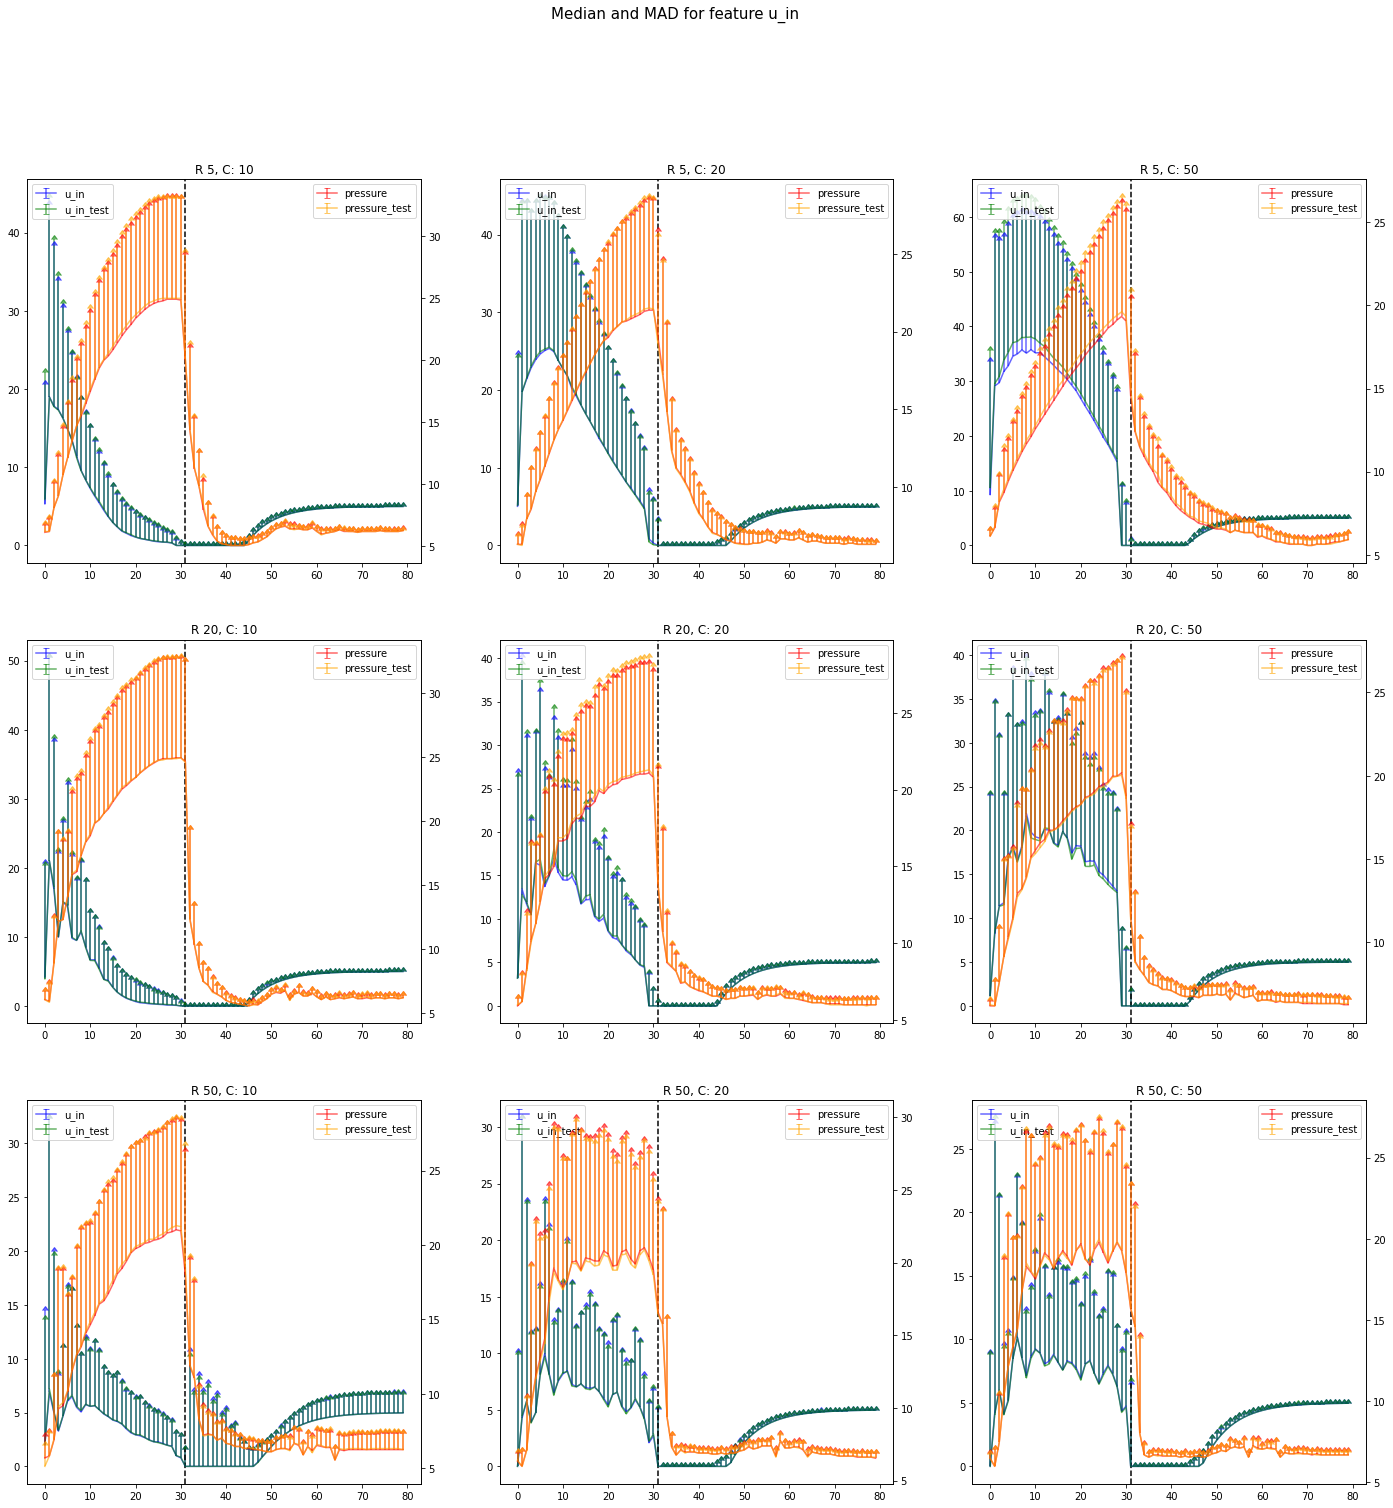

In [24]:
feature_plot(train, test, "u_in", use_median=True)

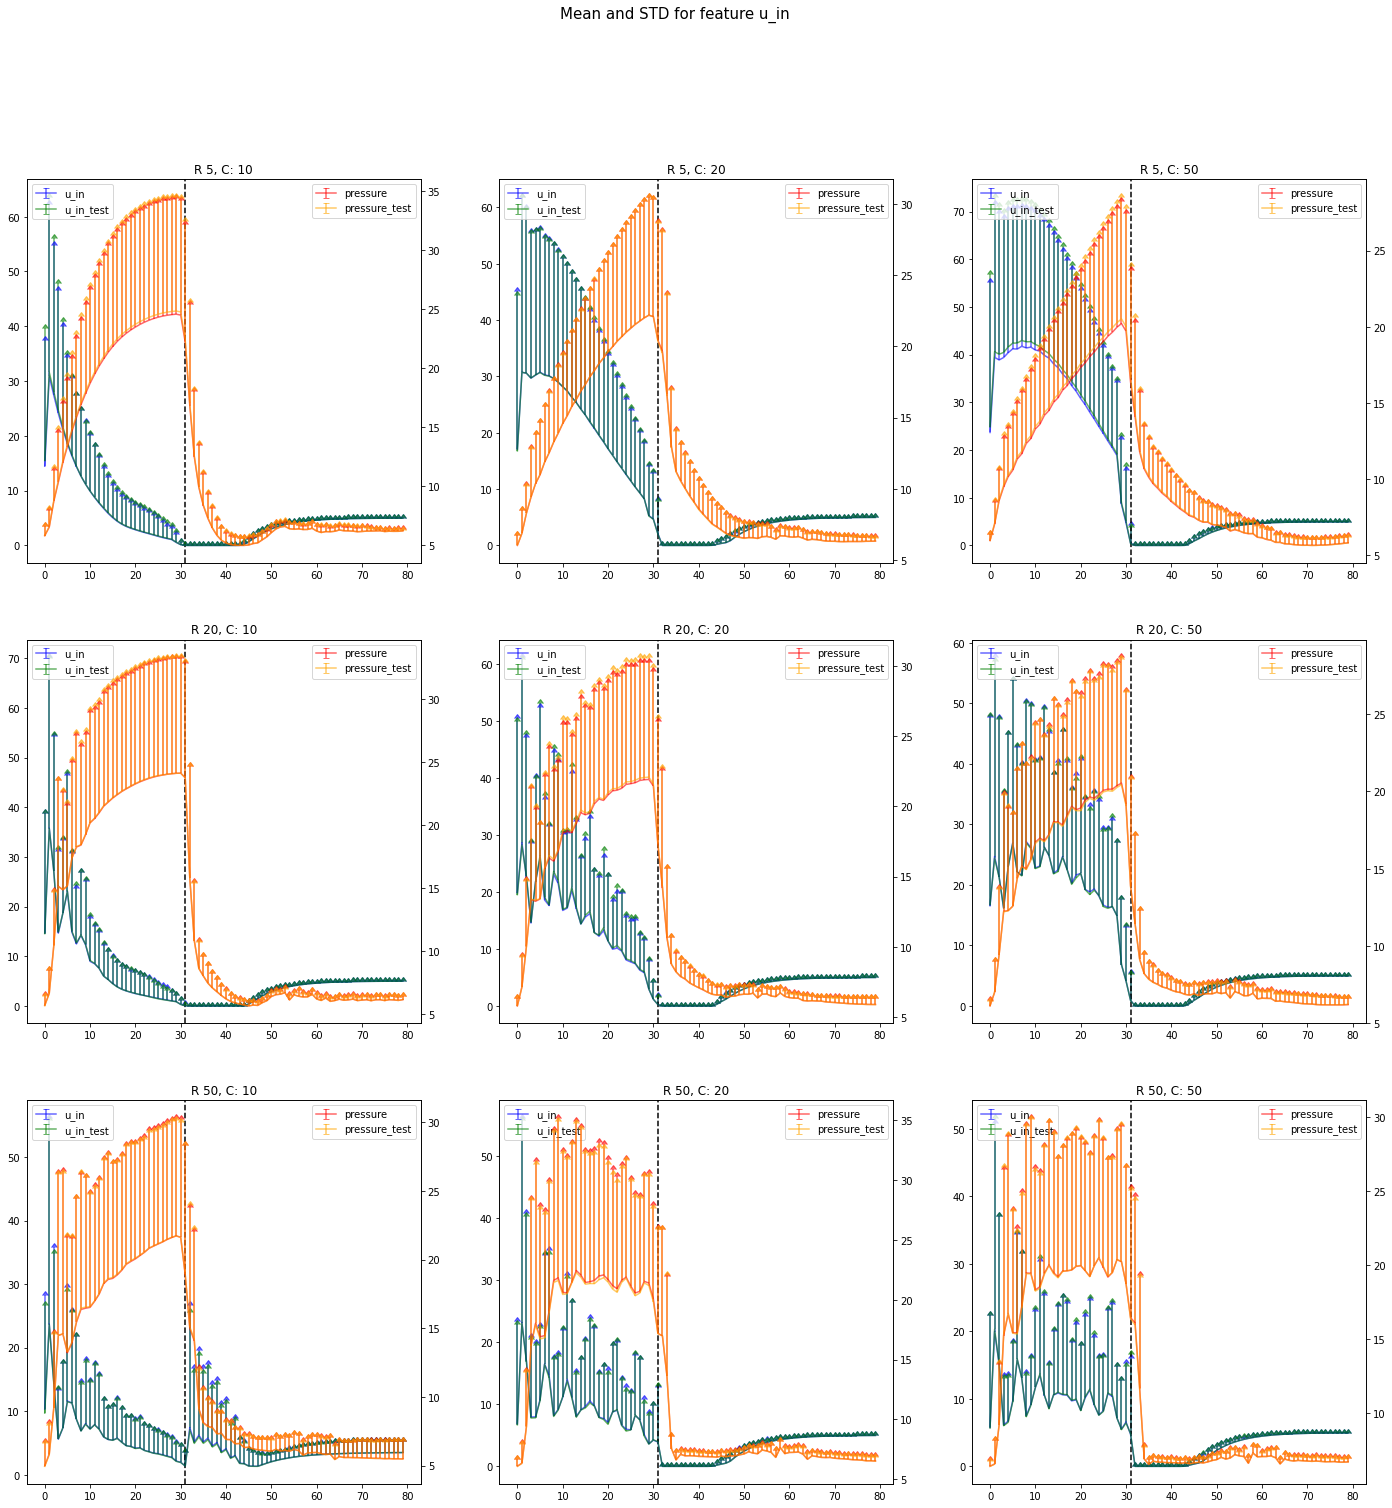

In [25]:
feature_plot(train, test, "u_in", use_median=False)

# Features

In [26]:
train_group = train.groupby("breath_id")
test_group = test.groupby("breath_id")

## u_in_cumsum

In [27]:
train["u_in_cumsum"] = train_group["u_in"].cumsum()
test["u_in_cumsum"] = test_group["u_in"].cumsum()

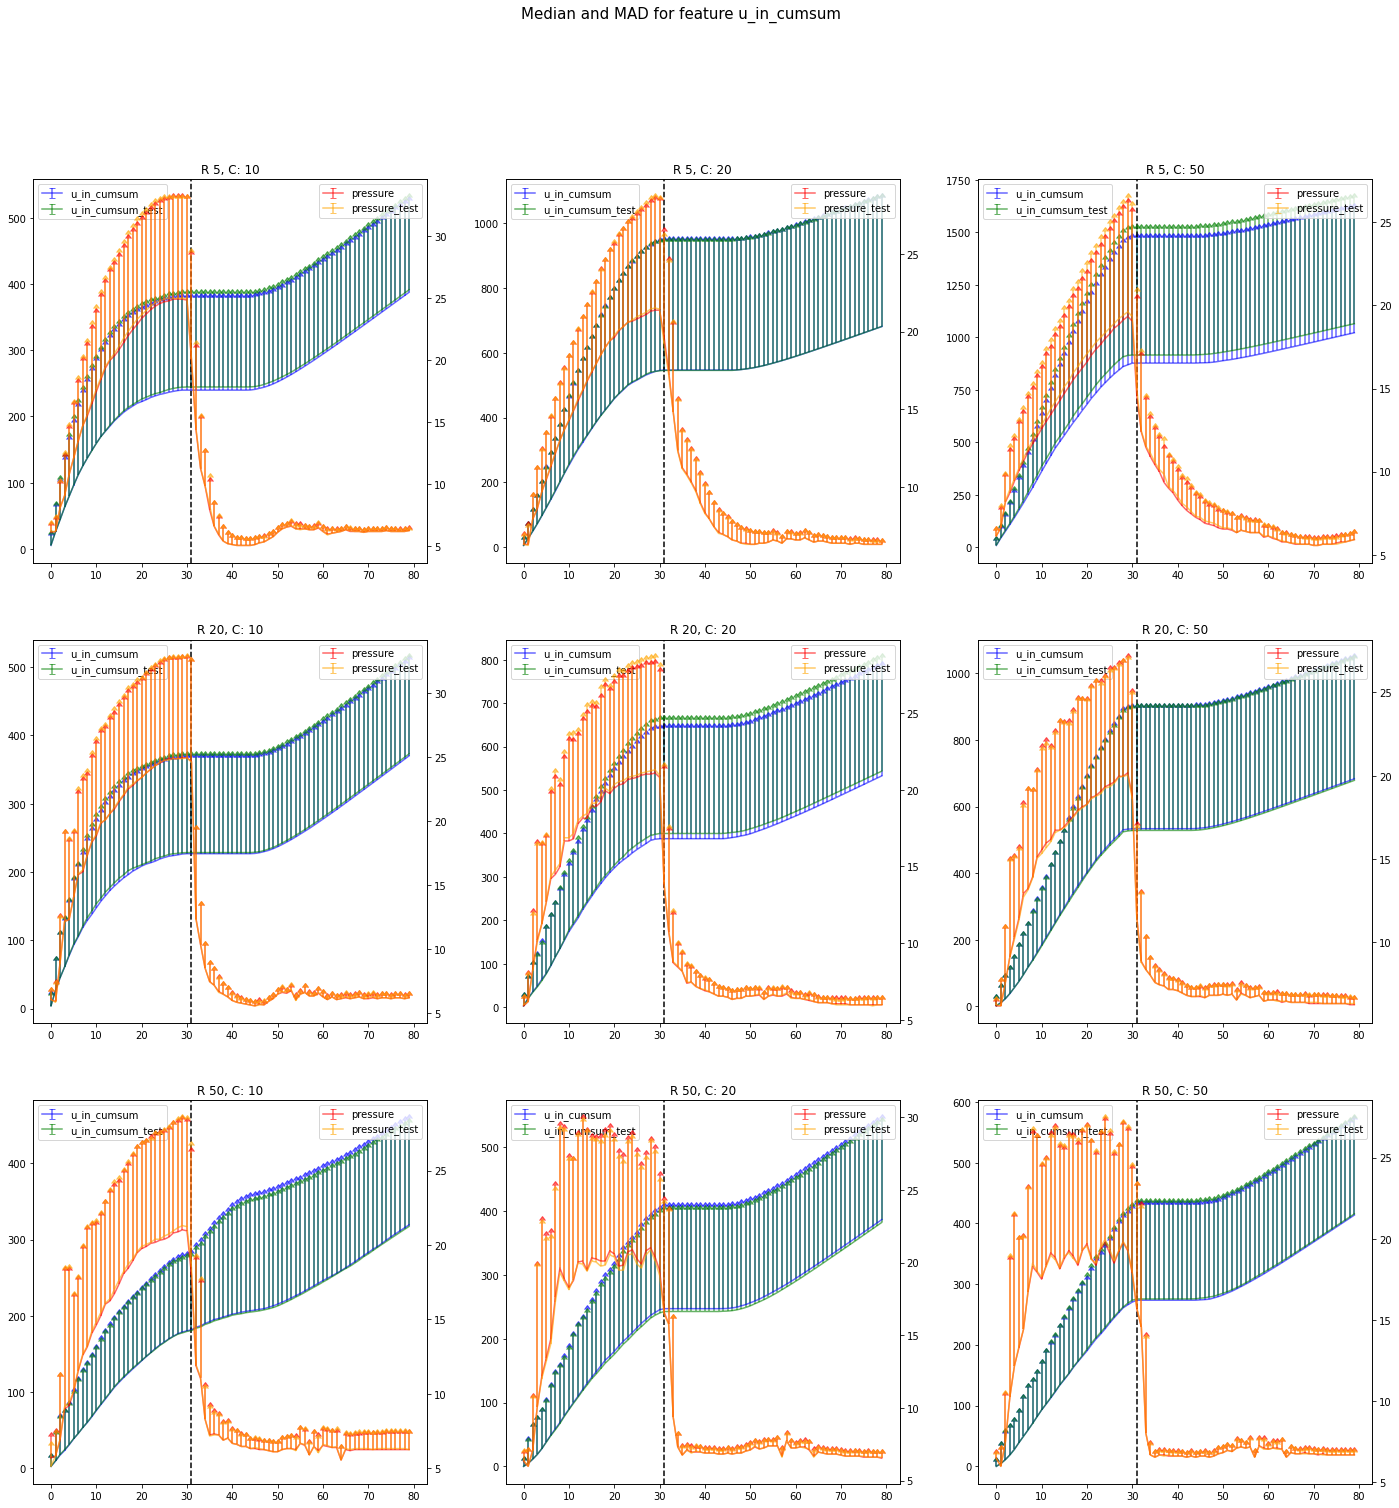

In [28]:
feature_plot(train, test, "u_in_cumsum")

## Area

In [29]:
train['area'] = train['time_step'] * train['u_in']
train['area'] = train.groupby('breath_id')['area'].cumsum()
test['area'] = test['time_step'] * test['u_in']
test['area'] = test.groupby('breath_id')['area'].cumsum()

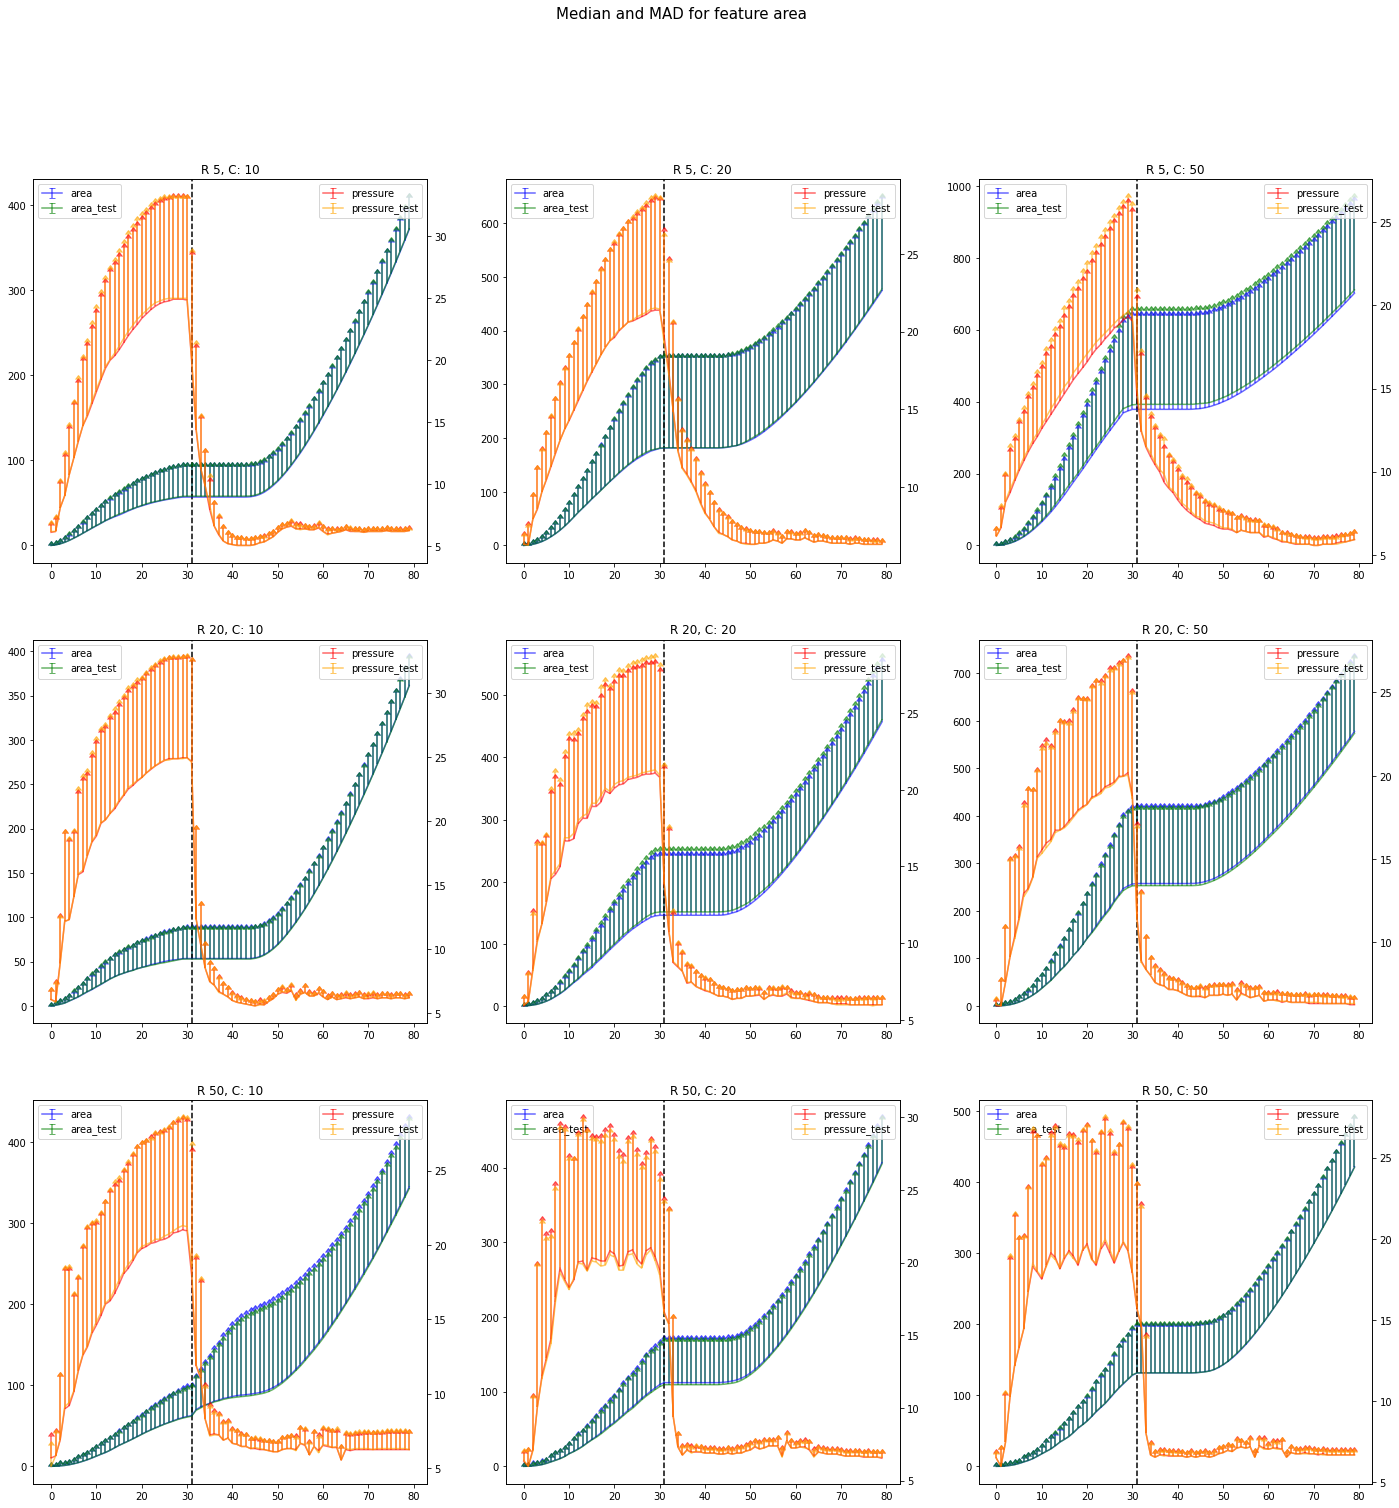

In [30]:
feature_plot(train, test, "area")

## Expand

### Mean &  median

In [31]:
train['expand_mean'] = train.groupby('breath_id')['u_in'].expanding().mean().reset_index(level=0, drop=True).fillna(0)
test['expand_mean'] = test.groupby('breath_id')['u_in'].expanding().mean().reset_index(level=0, drop=True)
train['expand_median'] = train.groupby('breath_id')['u_in'].expanding().median().reset_index(level=0, drop=True)
test['expand_median'] = test.groupby('breath_id')['u_in'].expanding().median().reset_index(level=0, drop=True)

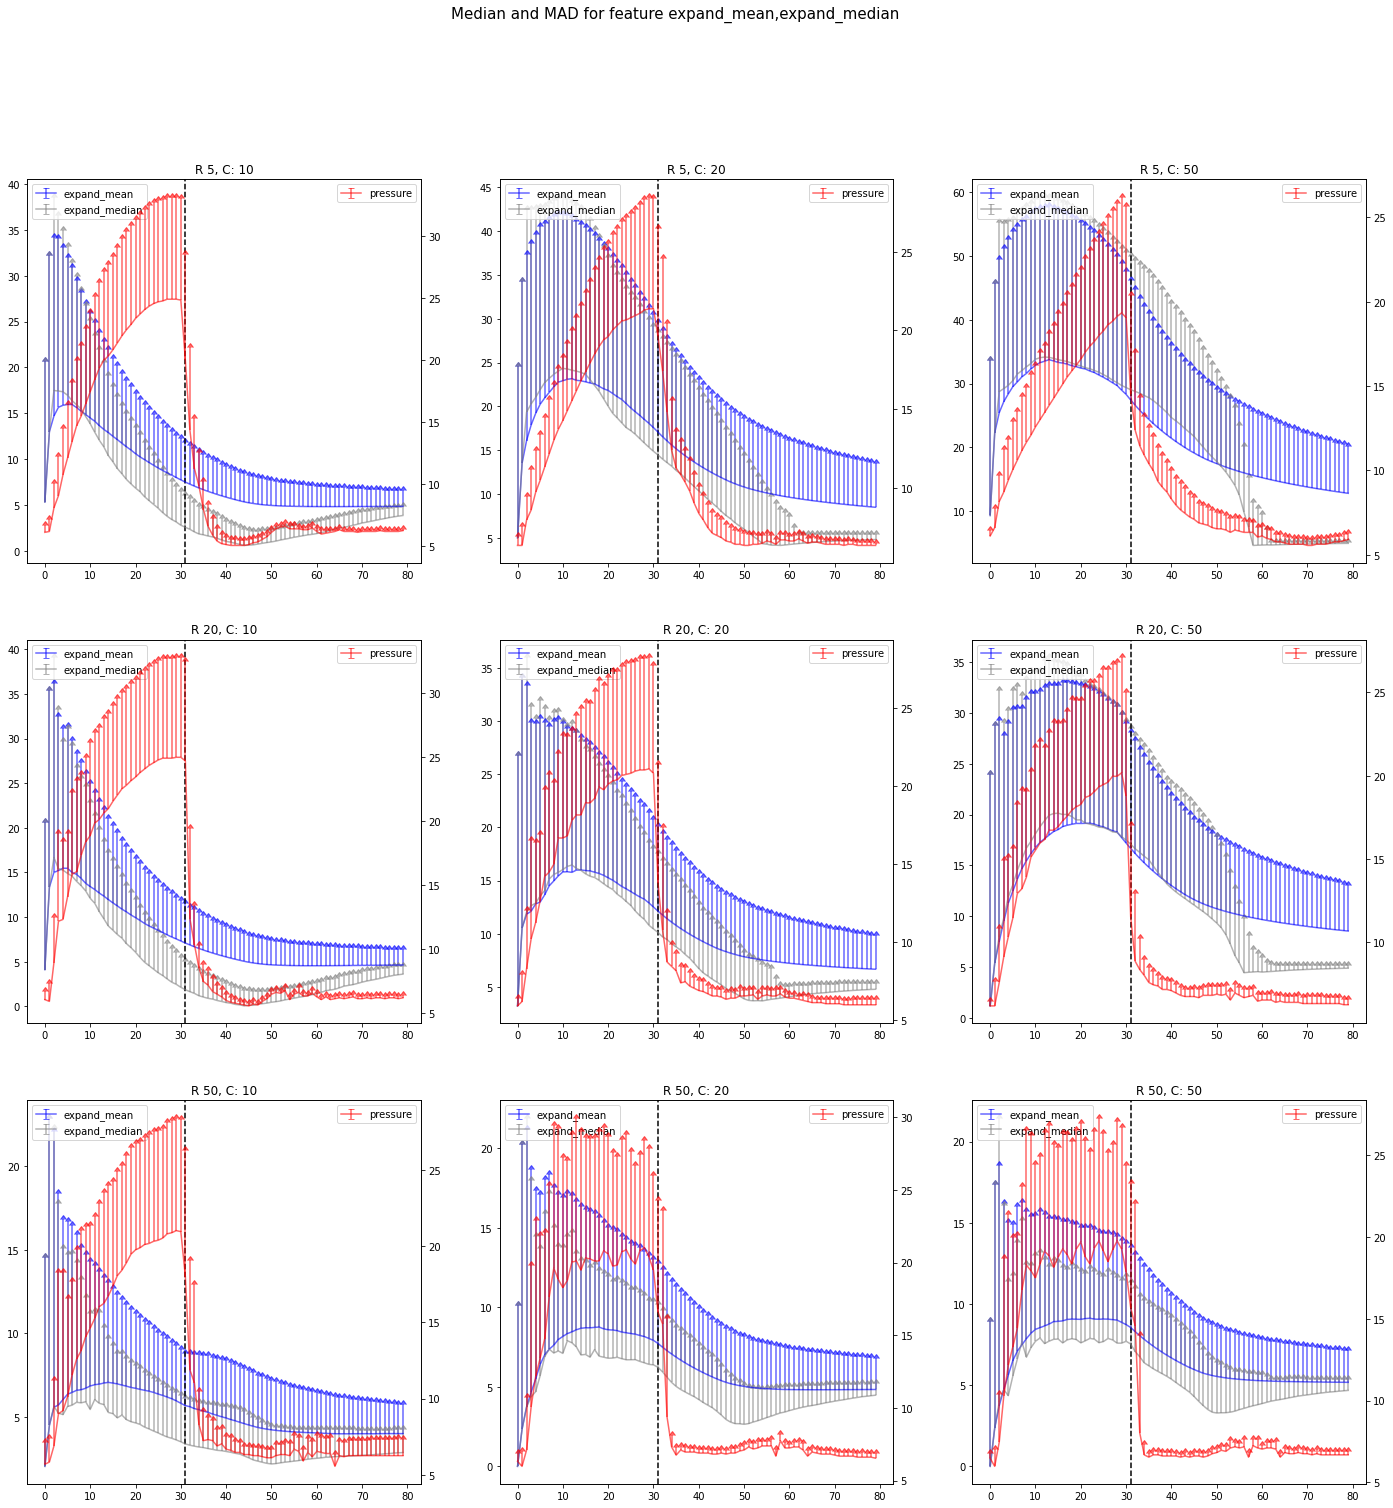

In [32]:
feature_plot(train, test, ["expand_mean", "expand_median"], use_median=True, plot_test=False)

### STD and MAD

In [33]:
train['expand_std'] = train.groupby('breath_id')['u_in'].expanding().std().reset_index(level=0, drop=True).fillna(0)
test['expand_std'] = test.groupby('breath_id')['u_in'].expanding().std().reset_index(level=0, drop=True).fillna(0)
# TODO
#train['expand_mad'] = train.groupby('breath_id')['u_in'].expanding(1).mad().reset_index(level=0, drop=True).fillna(0)
#test['expand_mad'] = test.groupby('breath_id')['u_in'].expanding(1).mad().reset_index(level=0, drop=True).fillna(0)

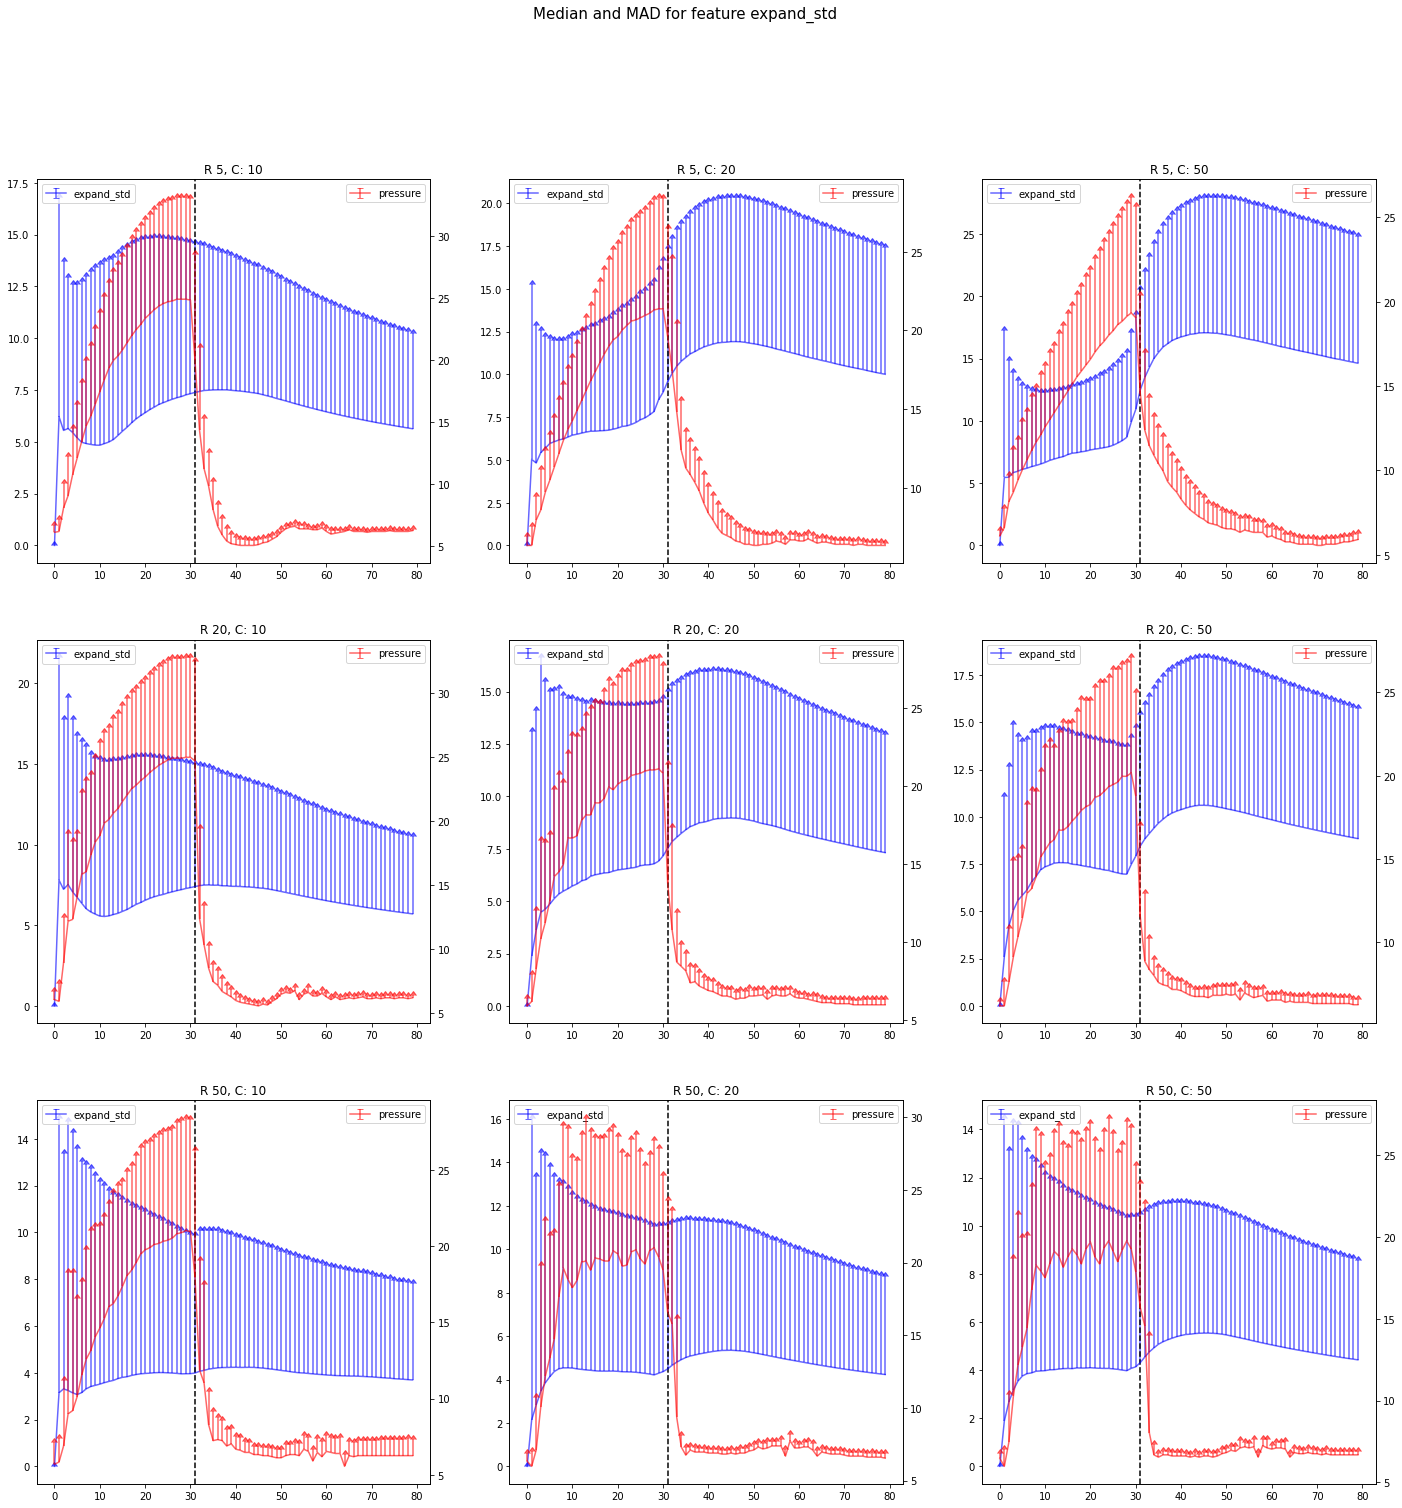

In [34]:
feature_plot(train, test, ["expand_std"], use_median=True, plot_test=False)

### MAX

In [35]:
train['expand_max'] = train.groupby('breath_id')['u_in'].expanding().max().reset_index(level=0, drop=True).fillna(0)
test['expand_max'] = test.groupby('breath_id')['u_in'].expanding().max().reset_index(level=0, drop=True).fillna(0)

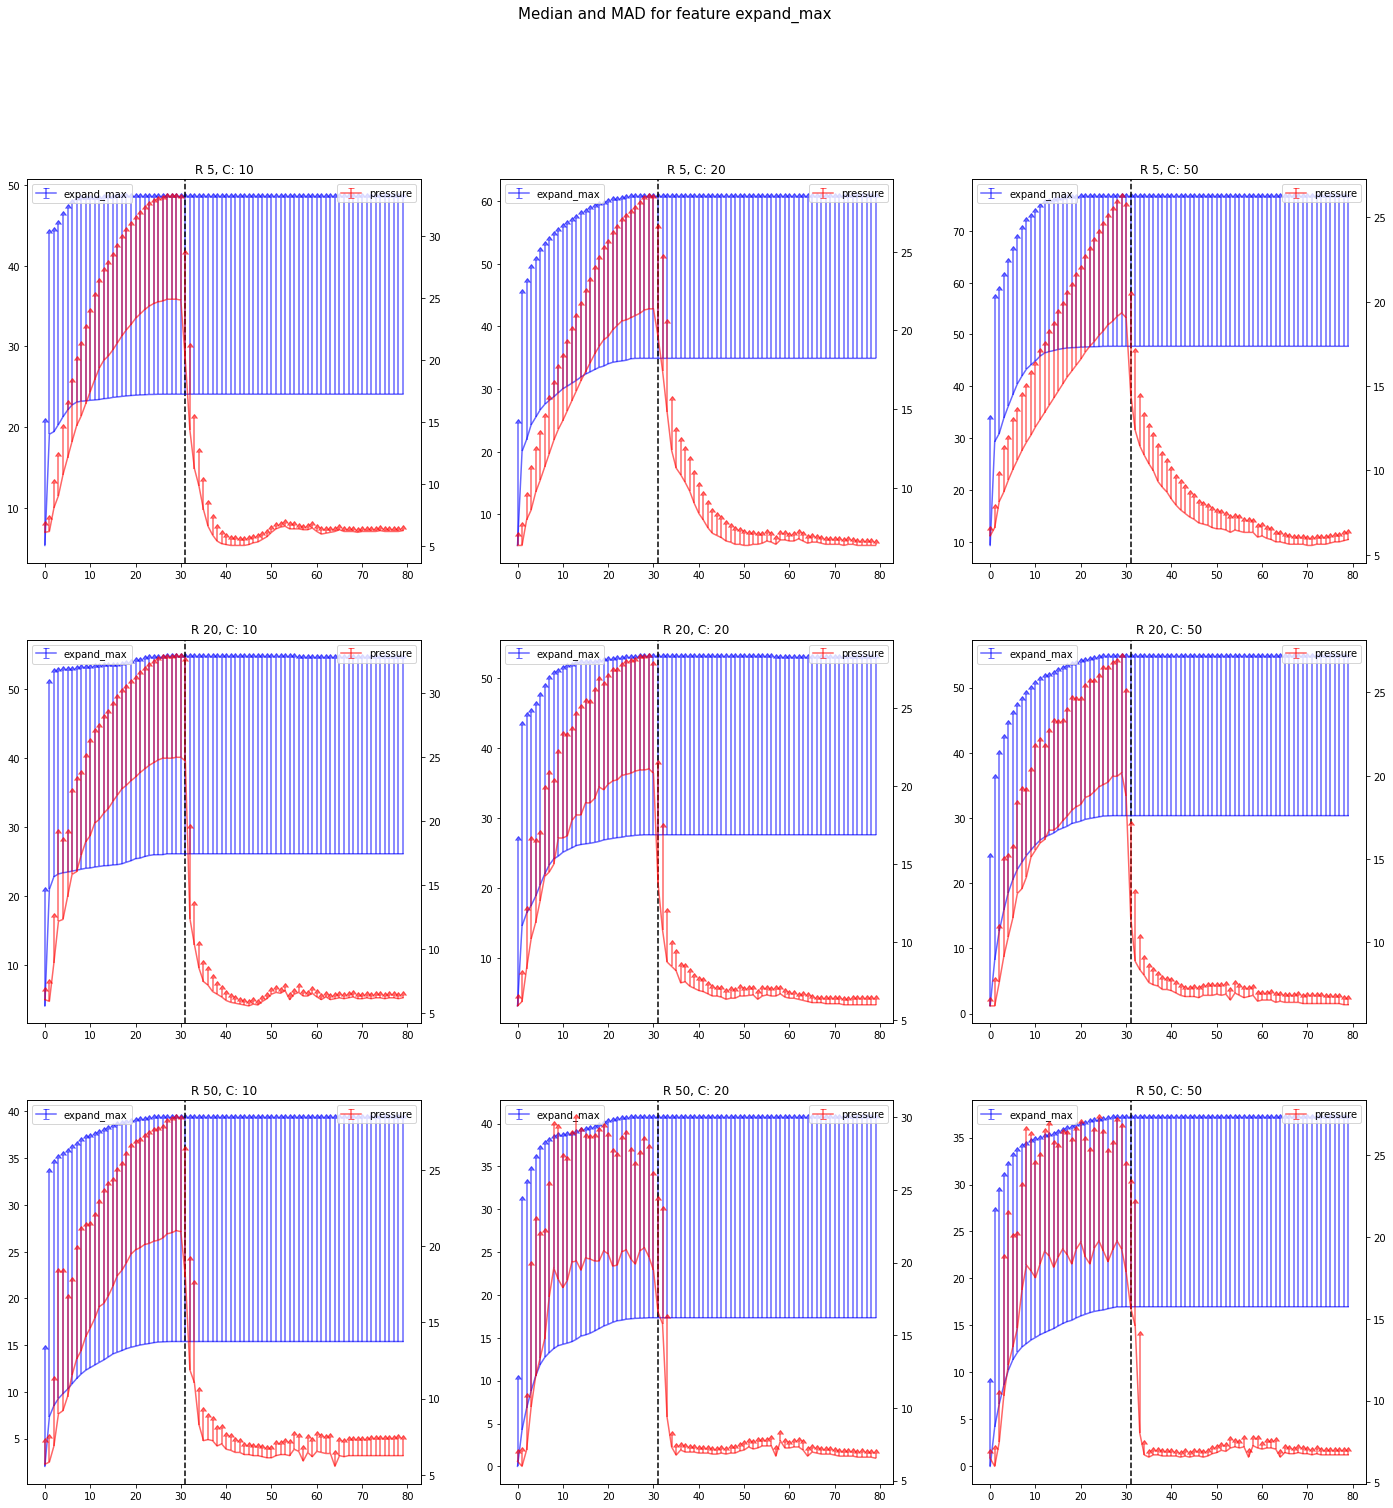

In [36]:
feature_plot(train, test, ["expand_max"], use_median=True, plot_test=False)

### Skew

In [37]:
train['expand_skew'] = train.groupby('breath_id')['u_in'].expanding().skew().reset_index(level=0, drop=True).fillna(0)
test['expand_skew'] = test.groupby('breath_id')['u_in'].expanding().skew().reset_index(level=0, drop=True).fillna(0)

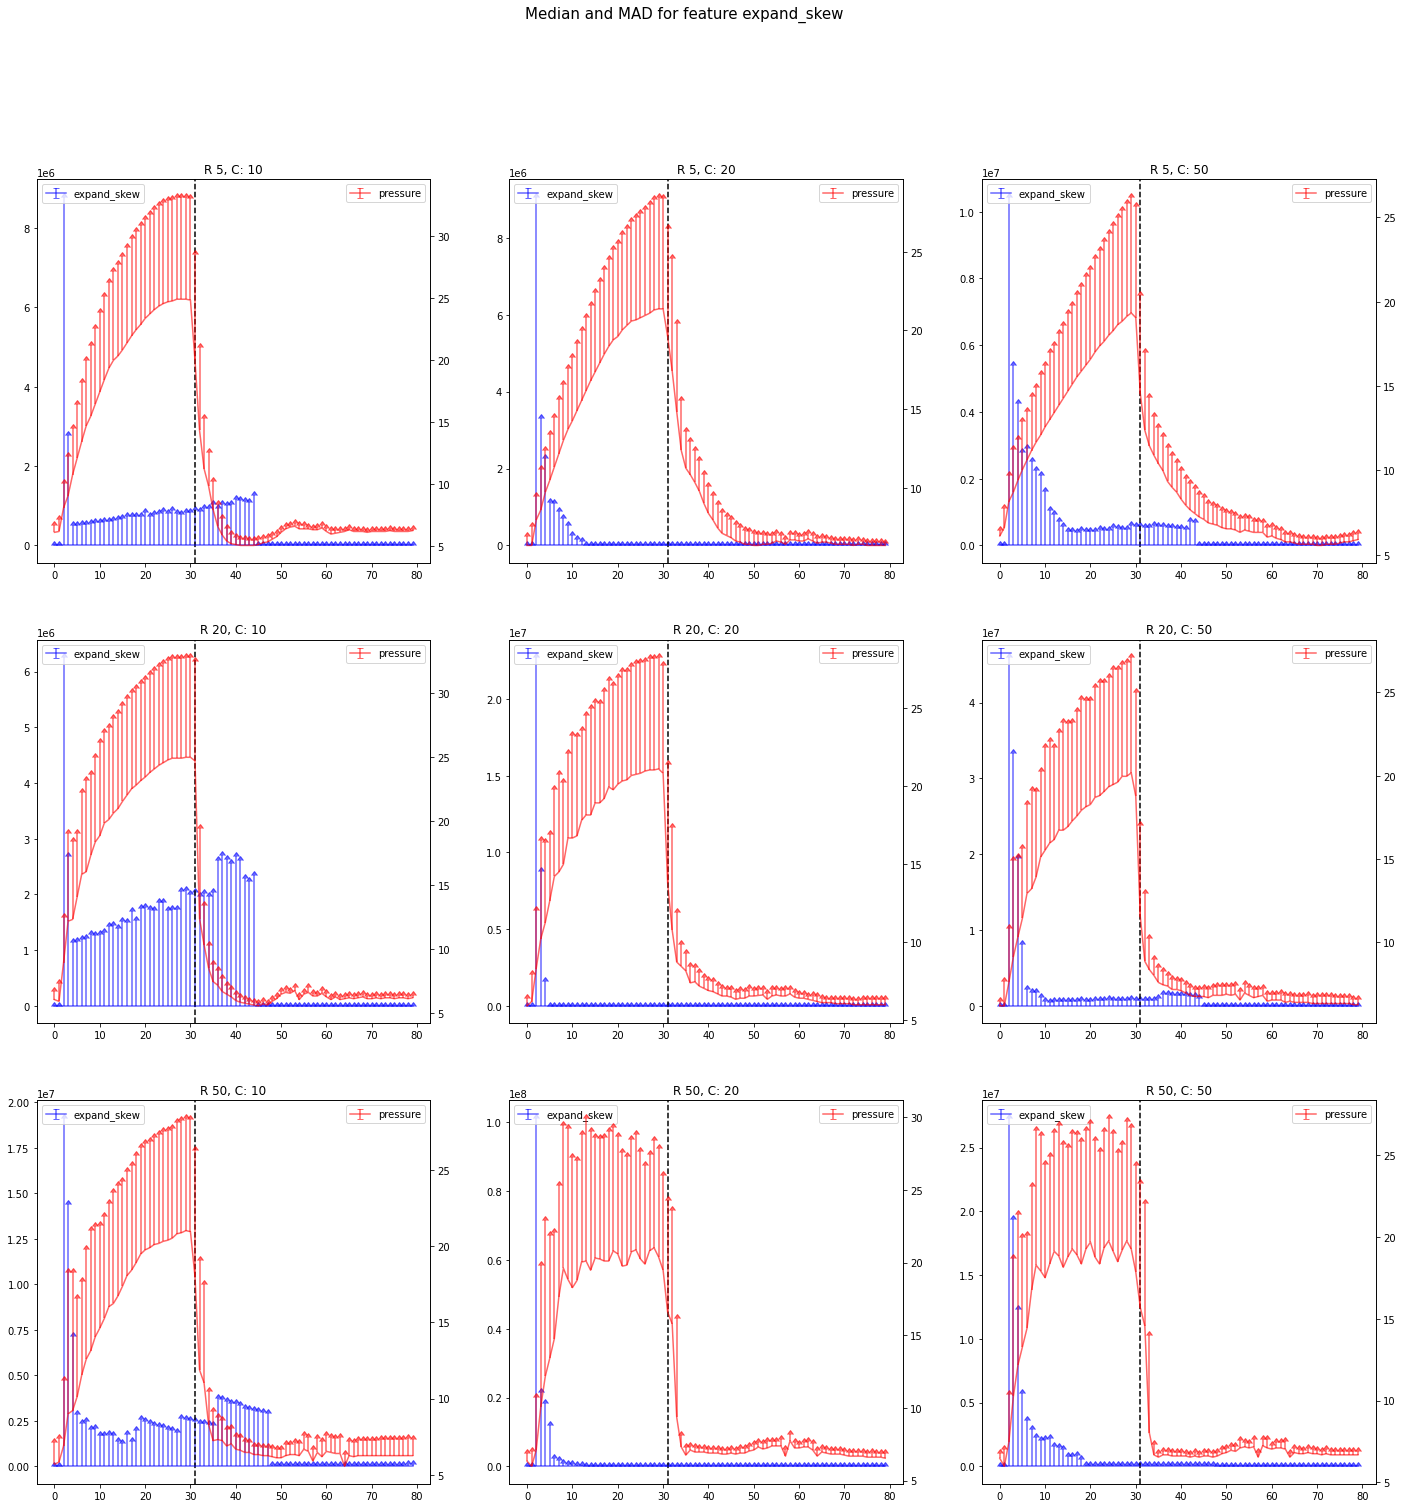

In [38]:
feature_plot(train, test, ["expand_skew"], use_median=True, plot_test=False)

### Kurt

In [39]:
train['expand_kurt'] = train.groupby('breath_id')['u_in'].expanding().kurt().reset_index(level=0, drop=True).fillna(0)
test['expand_kurt'] = test.groupby('breath_id')['u_in'].expanding().kurt().reset_index(level=0, drop=True).fillna(0)

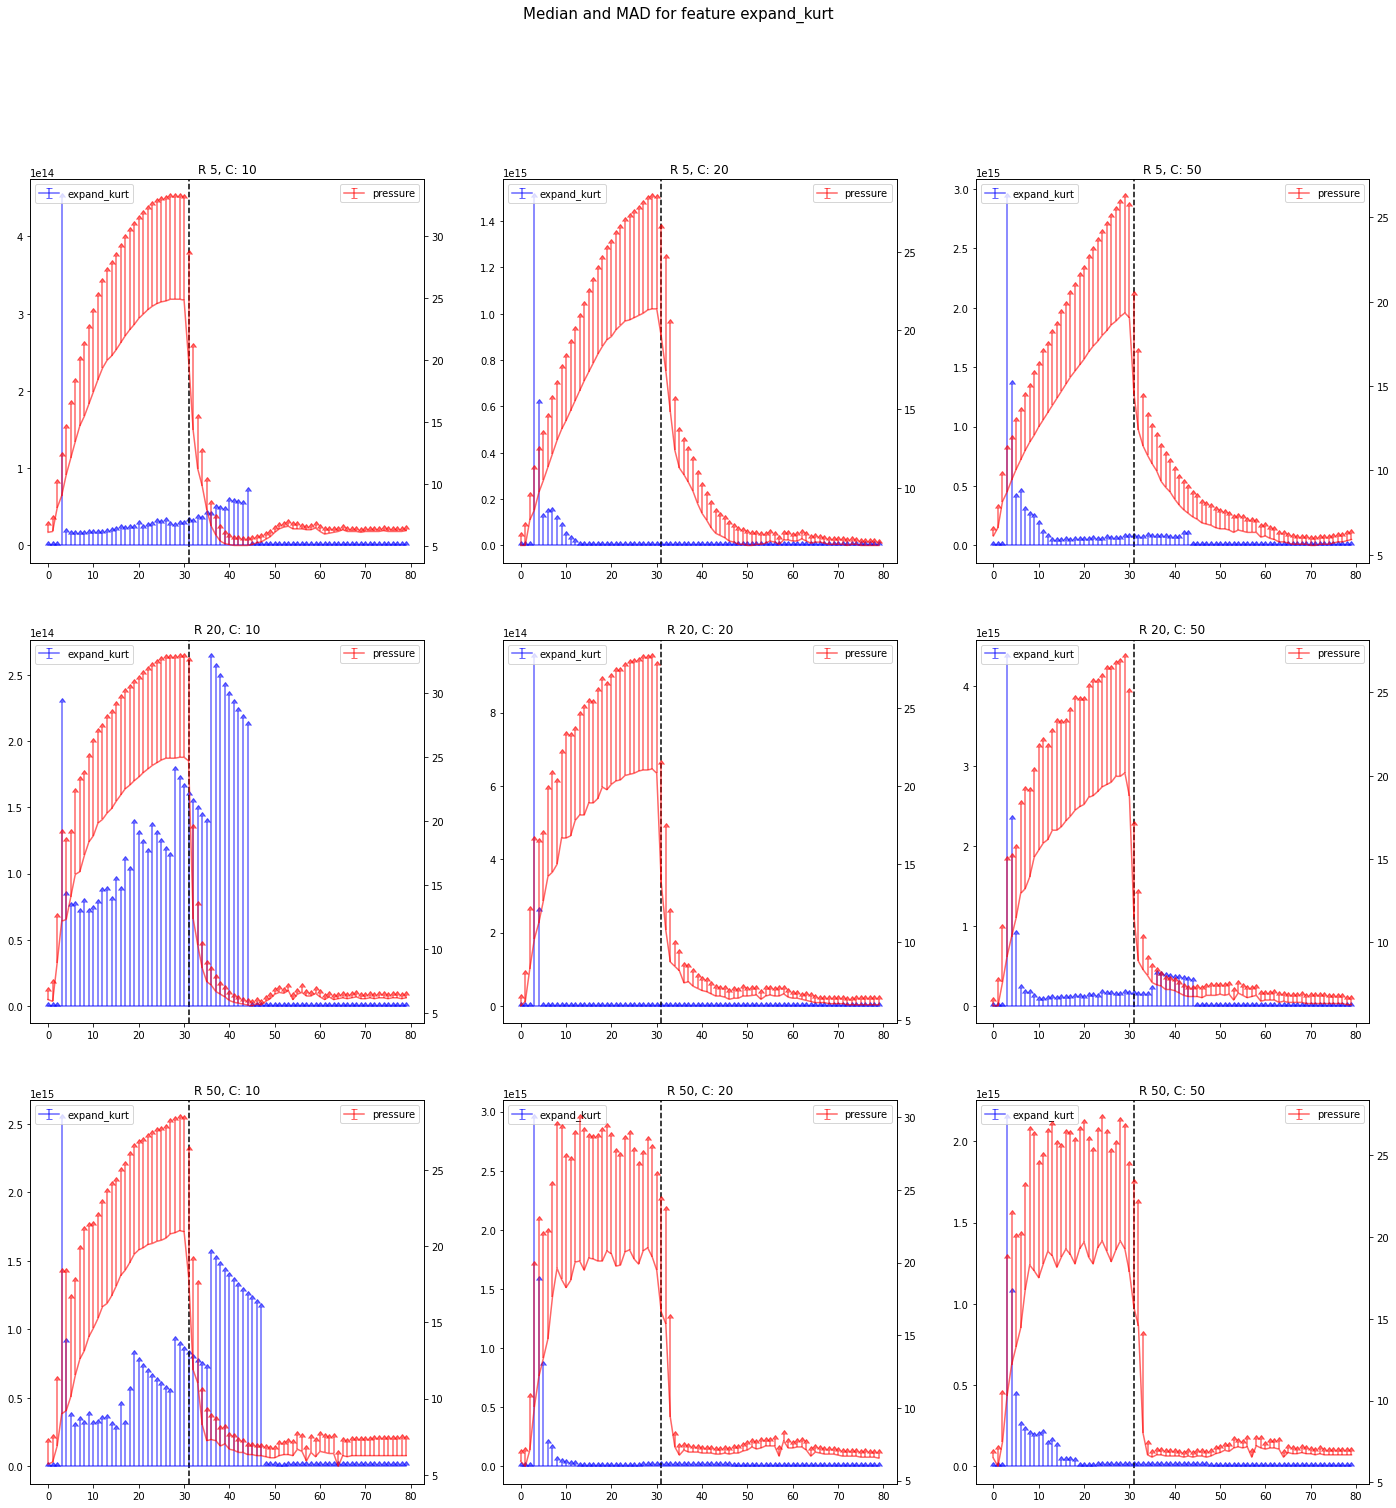

In [40]:
feature_plot(train, test, ["expand_kurt"], use_median=True, plot_test=False)

## Time Step

In [41]:
train["time_step_diff"] = train.groupby('breath_id')['time_step'].diff().fillna(0.03343)
test["time_step_diff"] = test.groupby('breath_id')['time_step'].diff().fillna(0.03343)

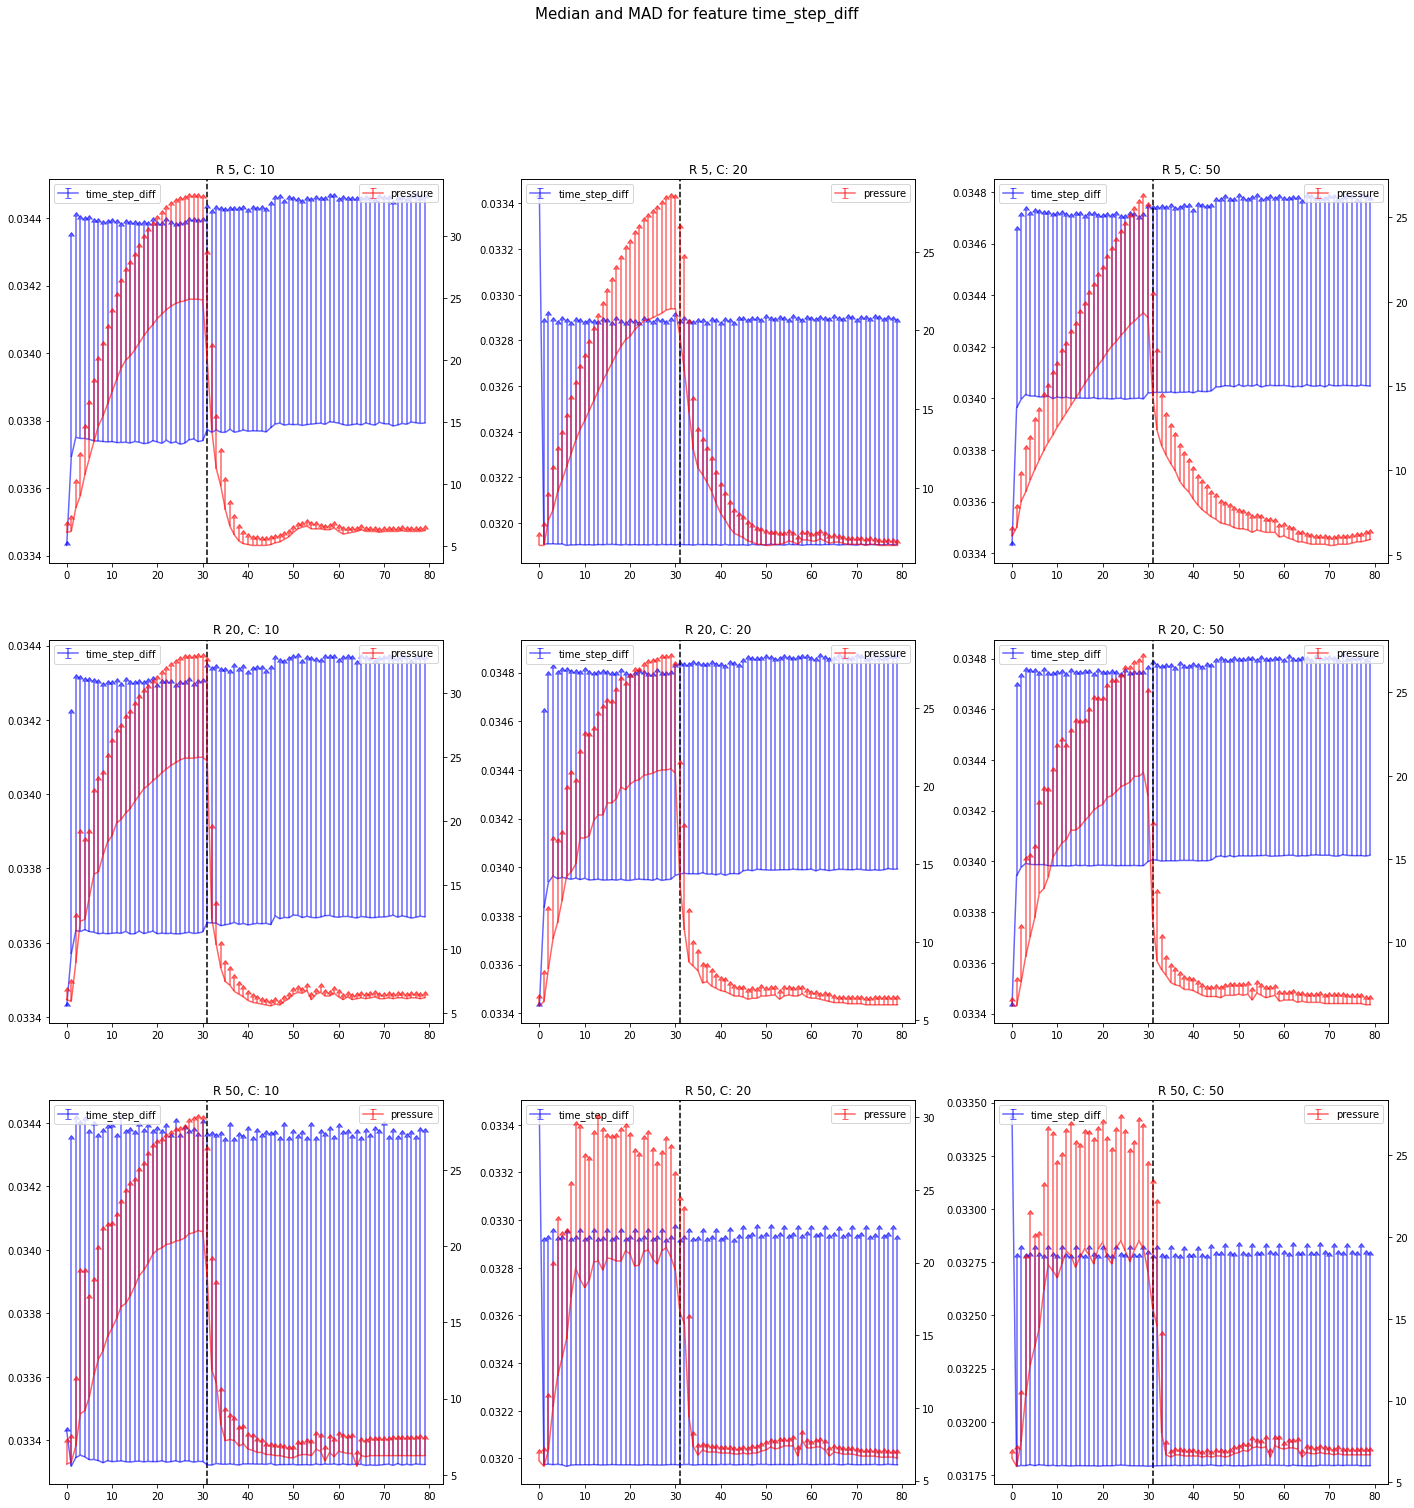

In [42]:
feature_plot(train, test, "time_step_diff", use_median=True, plot_test=False)

## Cross Sectional

In [43]:
RC_u_in_median = train.groupby(["R","C","step"])["u_in"].median()
RC_u_in_mean = train.groupby(["R","C","step"])["u_in"].mean()

In [44]:
train = train.merge(RC_u_in_median.to_frame("RC_u_in_median"), left_on=["R","C","step"], right_index=True)
train = train.merge(RC_u_in_mean.to_frame("RC_u_in_mean"), left_on=["R","C","step"], right_index=True)

In [45]:
train["RC_u_in_median_diff"] = train["u_in"] -  train["RC_u_in_median"]
train["RC_u_in_mean_diff"] = train["u_in"] -  train["RC_u_in_mean"]

In [46]:
train.drop(columns=["RC_u_in_median","RC_u_in_mean"], inplace=True)

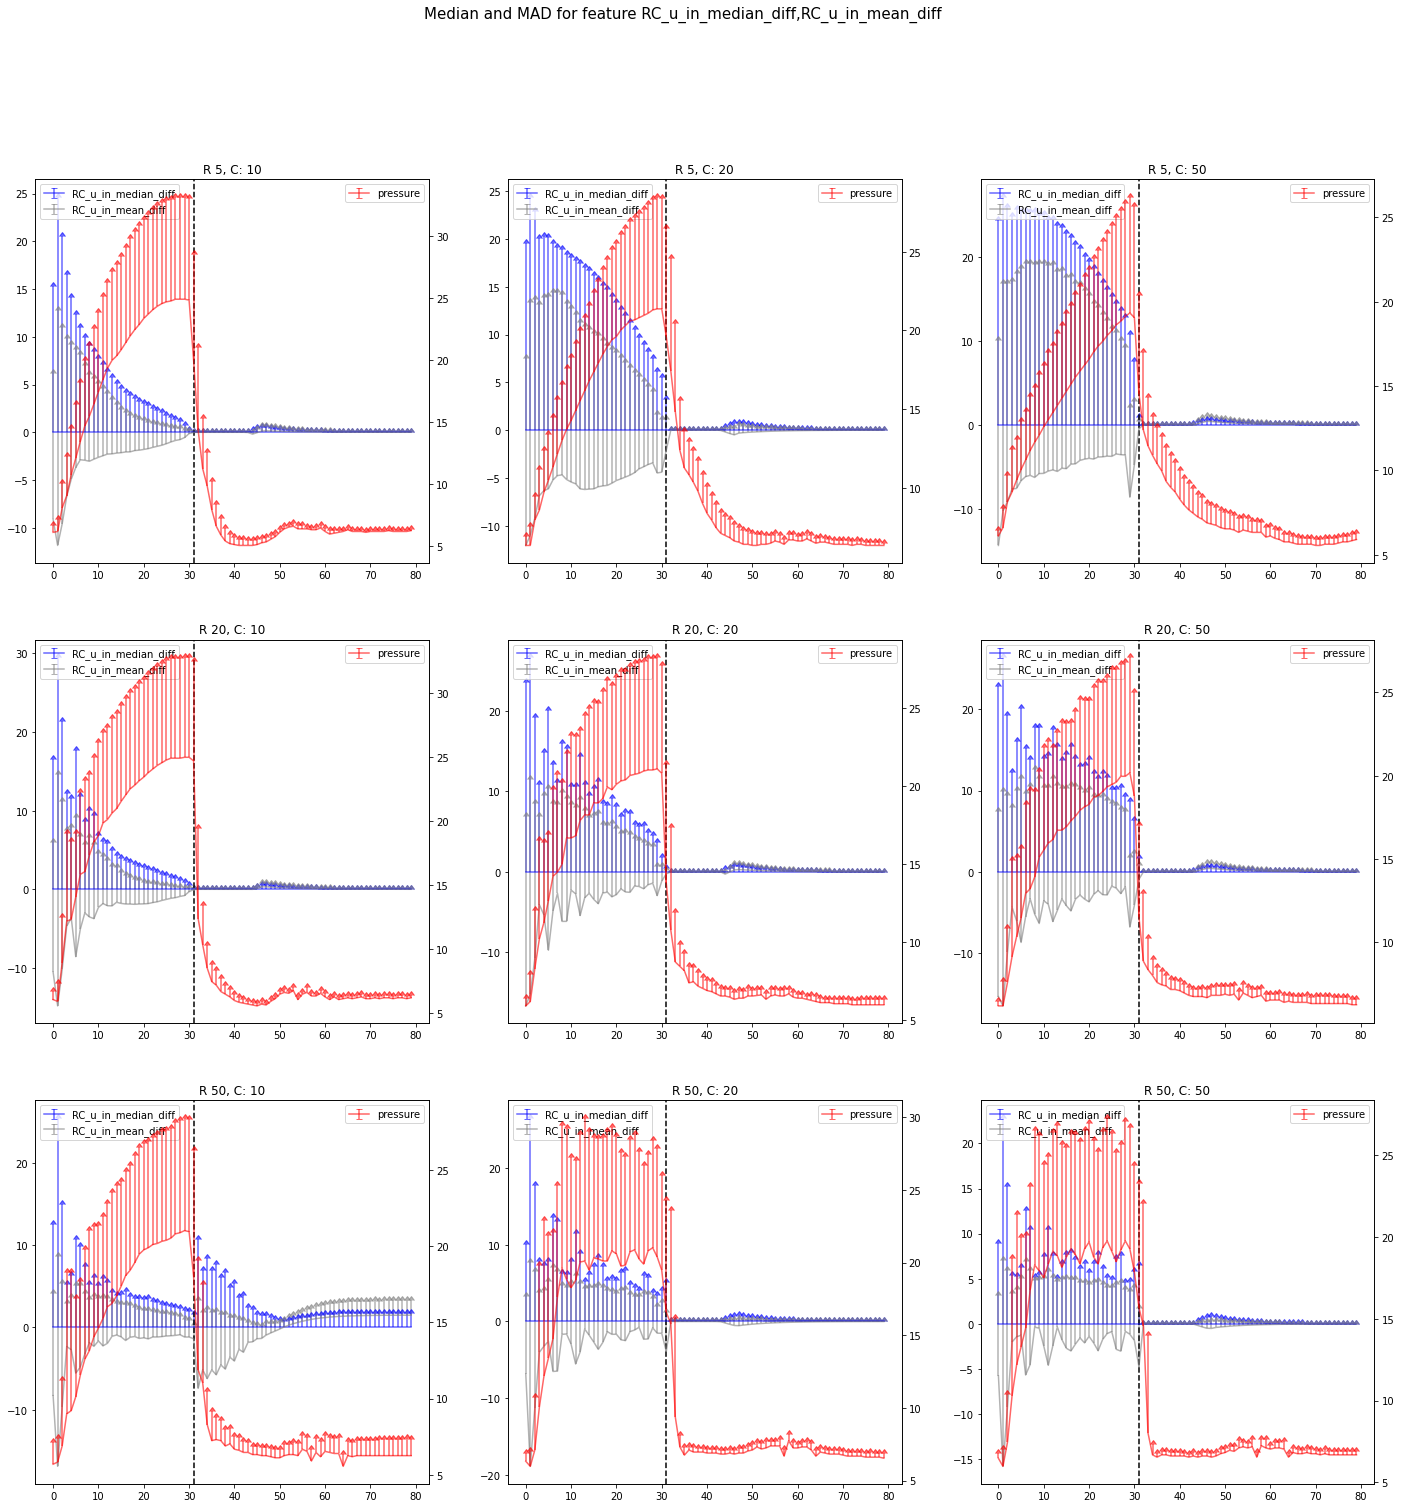

In [47]:
feature_plot(train, test, ["RC_u_in_median_diff","RC_u_in_mean_diff"], use_median=True, plot_test=False)

# Pipeline Constructed Features

In [58]:
train_fe = FE.add_features(train[['id','breath_id','R','C','time_step','u_in','u_out','pressure']].sort_values("id").copy())
test_fe = FE.add_features(test[['id','breath_id','R','C','time_step','u_in','u_out']].sort_values("id").copy())

In [61]:
train_fe.head()

id  breath_id  time_step       u_in  u_out   pressure  step  time_delta  \
0   1          1   0.000000   0.083334      0   5.837492     0    0.000000   
1   2          1   0.033652  18.383041      0   5.907794     1    0.033652   
2   3          1   0.067514  22.509278      0   7.876254     2    0.033862   
3   4          1   0.101542  22.808822      0  11.742872     3    0.034028   
4   5          1   0.135756  25.355850      0  12.234987     4    0.034213   

       area  u_in_cumsum  ...  C_50  R_C_20_10  R_C_20_20  R_C_20_50  \
0  0.000000     0.083334  ...     1          0          0          1   
1  0.618632    18.466375  ...     1          0          0          1   
2  1.380843    40.975653  ...     1          0          0          1   
3  2.156978    63.784476  ...     1          0          0          1   
4  3.024485    89.140326  ...     1          0          0          1   

   R_C_50_10  R_C_50_20  R_C_50_50  R_C_5_10  R_C_5_20  R_C_5_50  
0          0          0          0         0         0         0  
1          0          0          0         0         0         0  
2          0          0          0         0         0         0  
3          0          0          0         0         0         0  
4          0          0          0         0         0         0  

[5 rows x 62 columns]

In [62]:
train_fe.columns

Index(['id', 'breath_id', 'time_step', 'u_in', 'u_out', 'pressure', 'step',
       'time_delta', 'area', 'u_in_cumsum', 'u_out_diff', 'cross_time',
       'cross_u_in', 'u_in_first', 'u_in_last', 'time_end', 'u_in_lag1',
       'u_in_lag_back1', 'u_in_lag2', 'u_in_lag_back2', 'u_in_lag3',
       'u_in_lag_back3', 'u_in_lag4', 'u_in_lag_back4', 'u_out_lag_back1',
       'u_out_lag_back2', 'u_in_diff', 'u_in_diff_2', 'u_in_diff_4',
       'ewm_u_in_mean', 'ewm_u_in_std', 'ewm_u_in_corr', 'rolling_10_mean',
       'rolling_10_max', 'rolling_10_std', 'expand_mean', 'expand_median',
       'expand_std', 'expand_max', 'expand_skew', 'expand_kurt', 'u_in_max',
       'u_in_mean', 'u_in_diffmax', 'u_in_diffmean', 'RC_u_in_median_diff',
       'RC_u_in_mean_diff', 'R_20', 'R_5', 'R_50', 'C_10', 'C_20', 'C_50',
       'R_C_20_10', 'R_C_20_20', 'R_C_20_50', 'R_C_50_10', 'R_C_50_20',
       'R_C_50_50', 'R_C_5_10', 'R_C_5_20', 'R_C_5_50'],
      dtype='object')

In [133]:
train_fe.query("time_delta!=0")['time_delta'].mean()

0.033098770961621796

In [166]:
train_fe.groupby("breath_id")["time_step"].first()

breath_id
1         0.0
2         0.0
3         0.0
4         0.0
5         0.0
         ... 
125740    0.0
125742    0.0
125743    0.0
125745    0.0
125749    0.0
Name: time_step, Length: 75450, dtype: float64

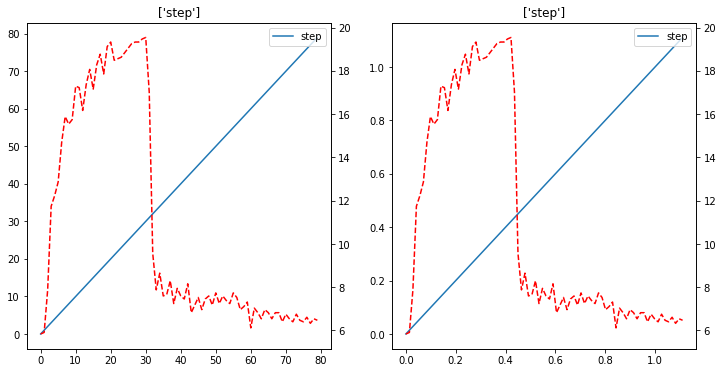

In [108]:
def plot_single(single_breath, cols, ax):
    x = single_breath["step"] if "step" in single_breath.columns else single_breath["time_step"]
    for col in cols:
        ax.plot(x, single_breath[col], label=col)
    if "pressure" in single_breath.columns:
        ax2 = ax.twinx()
        ax2.plot(x, single_breath['pressure'], label="pressure",color="red", linestyle="--")
    ax.set_title(cols)
    ax.legend(loc="upper right")
    return
single_breath = train_fe.query("breath_id == 1").copy()
feature_cols = [col for col in train_fe.columns if col not in ["id", "breath_id", "fold", "pressure"]]
rs = RobustScaler(quantile_range=(5, 95), unit_variance=False, with_centering=False, with_scaling=True)
single_breath_transform = single_breath.copy()
single_breath_transform[feature_cols] = rs.fit_transform(single_breath_transform[feature_cols])

cols_group1 = ["u_in","u_out"]
cols_group2 = ["area","u_in_cumsum"]
cols_group3 = ["u_out_diff", "u_in_first","u_in_last","time_end"]
cols_group4 = ["u_in", "u_in_lag1","ewm_u_in_mean","rolling_10_mean", "expand_mean"]
cols_group5 = ["ewm_u_in_std", "rolling_10_std","expand_std"]
cols_group6 = ["u_in_max","u_in_mean","u_in_diffmax","u_in_diffmean"]
cols_group7 = ["RC_u_in_median_diff","RC_u_in_mean_diff"]
cols_group8 = ["expand_skew","expand_kurt"]
cols_group9 = ["time_delta"]
cols_group10 = ["step"]

fig, axes = plt.subplots(1,2,figsize=(12,6))
plot_single(single_breath, cols=cols_group10,ax=axes[0])
plot_single(single_breath_transform, cols=cols_group10,ax=axes[1])
plt.show()

In [144]:
RobustScaler(quantile_range=(25, 75), unit_variance=False, with_centering=True, with_scaling=True).fit_transform(single_breath[["step"]]).flatten()

array([-1.        , -0.97468354, -0.94936709, -0.92405063, -0.89873418,
       -0.87341772, -0.84810127, -0.82278481, -0.79746835, -0.7721519 ,
       -0.74683544, -0.72151899, -0.69620253, -0.67088608, -0.64556962,
       -0.62025316, -0.59493671, -0.56962025, -0.5443038 , -0.51898734,
       -0.49367089, -0.46835443, -0.44303797, -0.41772152, -0.39240506,
       -0.36708861, -0.34177215, -0.3164557 , -0.29113924, -0.26582278,
       -0.24050633, -0.21518987, -0.18987342, -0.16455696, -0.13924051,
       -0.11392405, -0.08860759, -0.06329114, -0.03797468, -0.01265823,
        0.01265823,  0.03797468,  0.06329114,  0.08860759,  0.11392405,
        0.13924051,  0.16455696,  0.18987342,  0.21518987,  0.24050633,
        0.26582278,  0.29113924,  0.3164557 ,  0.34177215,  0.36708861,
        0.39240506,  0.41772152,  0.44303797,  0.46835443,  0.49367089,
        0.51898734,  0.5443038 ,  0.56962025,  0.59493671,  0.62025316,
        0.64556962,  0.67088608,  0.69620253,  0.72151899,  0.74

In [153]:
RobustScaler(quantile_range=(25, 75), unit_variance=True, with_centering=True, with_scaling=True).fit_transform(single_breath[["step"]]).std()

0.7886307128350744

In [120]:
single_breath["step"].quantile(.25)

19.75

In [163]:
np.random.

<function RandomState.normal>

In [158]:
single_breath["step"].apply(lambda x: (x-39.5)/(59.25-19.75)/0.5063291139240507)

0    -1.975
1    -1.925
2    -1.875
3    -1.825
4    -1.775
      ...  
75    1.775
76    1.825
77    1.875
78    1.925
79    1.975
Name: step, Length: 80, dtype: float64

In [147]:
np.array([-1.        , -0.97468354, -0.94936709, -0.92405063, -0.89873418,
       -0.87341772, -0.84810127, -0.82278481, -0.79746835, -0.7721519 ,
       -0.74683544, -0.72151899, -0.69620253, -0.67088608, -0.64556962,
       -0.62025316, -0.59493671, -0.56962025, -0.5443038 , -0.51898734,
       -0.49367089, -0.46835443, -0.44303797, -0.41772152, -0.39240506,
       -0.36708861, -0.34177215, -0.3164557 , -0.29113924, -0.26582278,
       -0.24050633, -0.21518987, -0.18987342, -0.16455696, -0.13924051,
       -0.11392405, -0.08860759, -0.06329114, -0.03797468, -0.01265823,
        0.01265823,  0.03797468,  0.06329114,  0.08860759,  0.11392405,
        0.13924051,  0.16455696,  0.18987342,  0.21518987,  0.24050633,
        0.26582278,  0.29113924,  0.3164557 ,  0.34177215,  0.36708861,
        0.39240506,  0.41772152,  0.44303797,  0.46835443,  0.49367089,
        0.51898734,  0.5443038 ,  0.56962025,  0.59493671,  0.62025316,
        0.64556962,  0.67088608,  0.69620253,  0.72151899,  0.74683544,
        0.7721519 ,  0.79746835,  0.82278481,  0.84810127,  0.87341772,
        0.89873418,  0.92405063,  0.94936709,  0.97468354,  1.        ]) == \
np.array([-1.        , -0.97468354, -0.94936709, -0.92405063, -0.89873418,
       -0.87341772, -0.84810127, -0.82278481, -0.79746835, -0.7721519 ,
       -0.74683544, -0.72151899, -0.69620253, -0.67088608, -0.64556962,
       -0.62025316, -0.59493671, -0.56962025, -0.5443038 , -0.51898734,
       -0.49367089, -0.46835443, -0.44303797, -0.41772152, -0.39240506,
       -0.36708861, -0.34177215, -0.3164557 , -0.29113924, -0.26582278,
       -0.24050633, -0.21518987, -0.18987342, -0.16455696, -0.13924051,
       -0.11392405, -0.08860759, -0.06329114, -0.03797468, -0.01265823,
        0.01265823,  0.03797468,  0.06329114,  0.08860759,  0.11392405,
        0.13924051,  0.16455696,  0.18987342,  0.21518987,  0.24050633,
        0.26582278,  0.29113924,  0.3164557 ,  0.34177215,  0.36708861,
        0.39240506,  0.41772152,  0.44303797,  0.46835443,  0.49367089,
        0.51898734,  0.5443038 ,  0.56962025,  0.59493671,  0.62025316,
        0.64556962,  0.67088608,  0.69620253,  0.72151899,  0.74683544,
        0.7721519 ,  0.79746835,  0.82278481,  0.84810127,  0.87341772,
        0.89873418,  0.92405063,  0.94936709,  0.97468354,  1.        ])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [81]:
single_breath = train_fe.query("breath_id == 1").copy()

<AxesSubplot:>

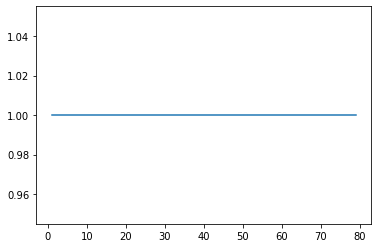

In [85]:
single_breath["pressure"].ewm(halflife=10).corr().plot()

In [83]:
single_breath["u_in"]

0      0.083334
1     18.383041
2     22.509278
3     22.808822
4     25.355850
        ...    
75     4.974474
76     4.978481
77     4.981847
78     4.984683
79     4.987079
Name: u_in, Length: 80, dtype: float64

In [60]:

gc.collect()

24

In [53]:
train_fe.query("breath_id == 1")

id  breath_id  time_step       u_in  u_out   pressure  step  time_delta  \
0    1          1   0.000000   0.083334      0   5.837492     0    0.000000   
1    2          1   0.033652  18.383041      0   5.907794    26    0.033652   
2    3          1   0.067514  22.509278      0   7.876254    52    0.033395   
3    4          1   0.101542  22.808822      0  11.742872    78    0.033320   
4    5          1   0.135756  25.355850      0  12.234987    24    0.033456   
..  ..        ...        ...        ...    ...        ...   ...         ...   
75  76          1   2.553593   4.974474      1   6.399909    30    0.033311   
76  77          1   2.587754   4.978481      1   6.610815    56    0.033502   
77  78          1   2.621773   4.981847      1   6.329607     2    0.033441   
78  79          1   2.655746   4.984683      1   6.540513    28    0.033367   
79  80          1   2.689766   4.987079      1   6.470211    54    0.033445   

         area  u_in_cumsum  ...  C_50  R_C_20_10  R_C_20_20  R_C_20_50  \
0    0.000000     0.083334  ...     1          0          0          1   
1    0.618632    18.466375  ...     1          0          0          1   
2    1.370325    40.975653  ...     1          0          0          1   
3    2.130314    63.784476  ...     1          0          0          1   
4    2.978627    89.140326  ...     1          0          0          1   
..        ...          ...  ...   ...        ...        ...        ...   
75  26.478847   791.748433  ...     1          0          0          1   
76  26.645636   796.726915  ...     1          0          0          1   
77  26.812232   801.708762  ...     1          0          0          1   
78  26.978558   806.693445  ...     1          0          0          1   
79  27.145351   811.680524  ...     1          0          0          1   

    R_C_50_10  R_C_50_20  R_C_50_50  R_C_5_10  R_C_5_20  R_C_5_50  
0           0          0          0         0         0         0  
1           0          0          0         0         0         0  
2           0          0          0         0         0         0  
3           0          0          0         0         0         0  
4           0          0          0         0         0         0  
..        ...        ...        ...       ...       ...       ...  
75          0          0          0         0         0         0  
76          0          0          0         0         0         0  
77          0          0          0         0         0         0  
78          0          0          0         0         0         0  
79          0          0          0         0         0         0  

[80 rows x 62 columns]

# Pipeline

In [15]:
train_fe.columns

Index(['id', 'breath_id', 'time_step', 'u_in', 'u_out', 'pressure', 'area',
       'u_in_cumsum', 'u_in_lag2', 'u_in_lag4', 'R_20', 'R_5', 'R_50', 'C_10',
       'C_20', 'C_50', 'ewm_u_in_mean', 'ewm_u_in_std', 'ewm_u_in_corr',
       'rolling_10_mean', 'rolling_10_max', 'rolling_10_std', 'expand_mean',
       'expand_max', 'expand_std'],
      dtype='object')

In [17]:
assert [col for col in train_fe.columns if col != "pressure"] == list(test_fe.columns)
train_fe.shape, test_fe.shape

((6036000, 25), (4024000, 24))

# Transform

In [18]:
id_rc_dict = train.groupby("breath_id")[["R","C"]].last()

In [23]:
train.groupby(["R","C"])[["pressure","u_"]]

TypeError: You have to supply one of 'by' and 'level'

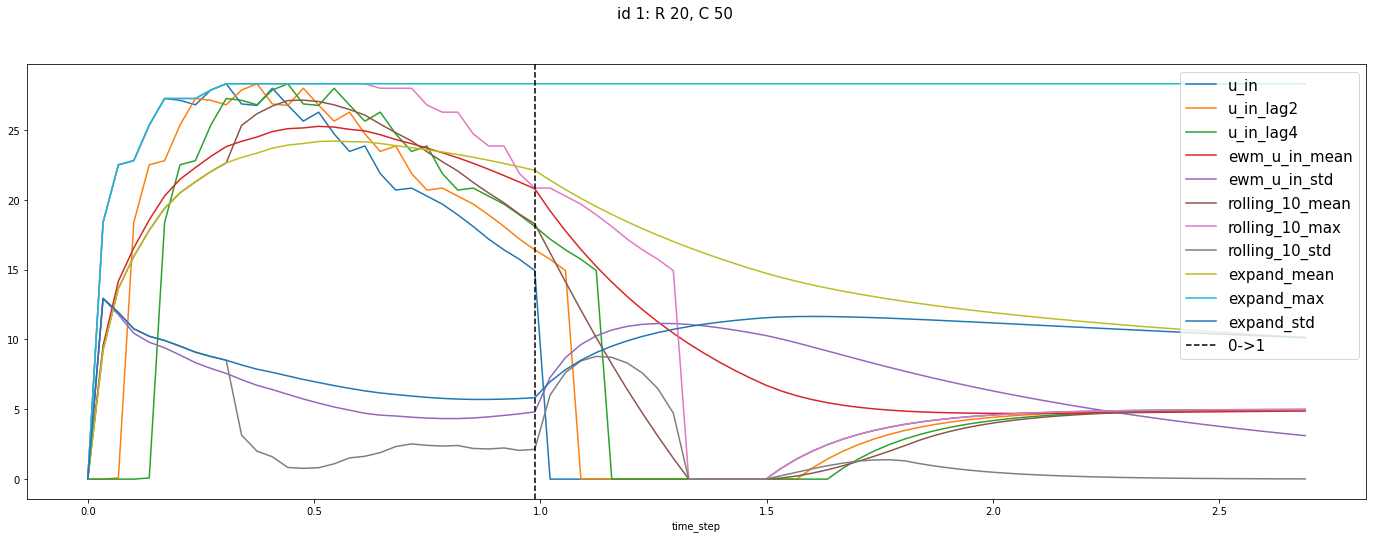

In [22]:
def plot_example(df, breath_id):
    fig, ax = plt.subplots(1,1,figsize=(24,8))
    tmp_df = df.query(f"breath_id == {breath_id}").copy()
    tmp_df.query("breath_id == 1").plot(x="time_step",
                                        y=["u_in","u_in_lag2","u_in_lag4",
                                           "ewm_u_in_mean", "ewm_u_in_std",
                                           "rolling_10_mean", "rolling_10_max", "rolling_10_std",
                                           "expand_mean","expand_max","expand_std"],
                                        secondary_y = "pressure",
                                        ax=ax)    
    change_place = tmp_df.iloc[tmp_df['u_out'].diff().idxmax()-1,:]["time_step"]
    ax.axvline(x=change_place, linestyle="--", alpha=1, label="0->1", color="black")
    plt.legend(fontsize=15)
    plt.suptitle(f"breath_id : {breath_id}, ")
    
    R, C = id_rc_dict.loc[breath_id, ['R','C']]    
    plt.suptitle(f"id {breath_id}: R {int(R)}, C {int(C)}", size=15)
    
    return
plot_example(train_fe, 1) 

<AxesSubplot:xlabel='time_step'>

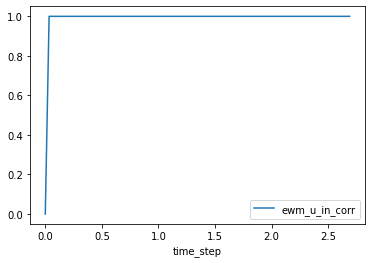

In [30]:
train_fe.query("breath_id == 1").plot(x="time_step",y=["ewm_u_in_corr"])

<AxesSubplot:xlabel='time_step'>

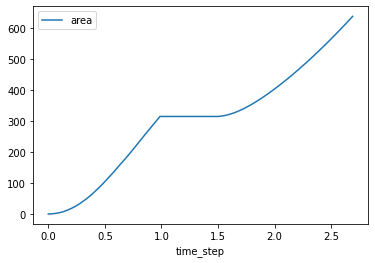

In [23]:
train_fe.query("breath_id == 1").plot(x="time_step",y="area")

<AxesSubplot:xlabel='time_step'>

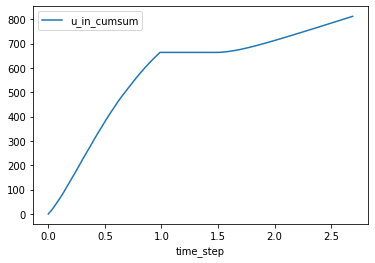

In [26]:
train_fe.query("breath_id == 1").plot(x="time_step",y="u_in_cumsum")

In [21]:
# train_fe.corr()